### Simulation of Smooth and Sparse radii distributions and analysis of fitting behaviour of $\ell_1$- and  $\ell_2$- regularized least-square

We use eq. 11 from Van Gelderen etal. (1994) to generate realistic restricted diffusion signal perpendicular to the cylinder orientataion.

$$ln(A) = ln(A_0) \cdot -2\gamma^2 g^2 \sum_{m=1}^{\infty} \frac{2 D_f\alpha_m^2\delta-2+2 e^{-D_f\alpha_m^2\delta}+2 e^{-D_f\alpha_m^2\Delta}-e^{-D_f\alpha_m^2(\Delta-\delta)}-e^{-D_f\alpha_m^2(\Delta+\delta)} }{D_f^2\alpha_m^6(R^2\alpha_m^2-1 )}$$

where  
$D_f$ is the unbounded (free) diffusion in the cylinder  
$R$ is the radius of the cylinder  
$\alpha_m$ is the $m^{th}$ root of the equation $J^\prime(xR)=0$  
$J^\prime(\cdot)$ is the first derivative of the Bessel function of the first kind  
$g$, $\Delta$ and $\delta$ are the acquistion parameters: diffusion gradient amplitude perpendicular to the cylinder, diffusion gradient beggining spacing and diffusion gradient application time, respectively.  
$\gamma$ is the gyromagnetic ratio of the proton  
$A$ is the MR signal  
$A_0$ is the MR signal with $g=0$

In [93]:
import numpy as np
import pylab as pl
from scipy.special import jnp_zeros

def cyl_par_van(gammagyro, g, D, sdel, bdel, R, maxM = 10):
	# Van Gelderen 1994, eq. 11
	# maxM = 10 is more than enough, 5 would work OK
	am = jnp_zeros(1,maxM) / float(R)
	am2 = am**2
	tot = 0
	for m in range(1,maxM+1):
		a = am2[m-1]
		tot += (2*D*a*sdel - 2 + 2*np.exp(-D*a*sdel) + 2*np.exp(-D*a*bdel) - np.exp(-D*a*(bdel-sdel)) - np.exp(-D*a*(bdel+sdel))) / (D**2 * a**3 * (a*R**2 - 1))
	tot *= -2 * gammagyro**2 * g**2
	return tot

To generate a signal from a distribution $H$ over the radii  
We first chose a dicretization of radii $\{R_i\}_{i=1}^N$  
We "evalute" the distribution at every $R_i$ to get unnormalized weights $\{T_i\}_{i=1}^N$ = $\{H(R_i)\}_{i=1}^N$  
We scale the $T_i$ proportionally to their cross-section area $\pi R_i^2$ to get unnormalized signal weights $W_i = T_i \pi R_i^2$  
Finally, we normalize the $W_i$ to unity sum;  $\overline{W}_i = \frac{W_i}{\sum_{j=1}^N W_j}$

In [94]:
def E_restricted_perp_distri(gperp, Dfree, sdel, bdel, Rs, Ws):
    N = len(Rs)
    lnS_cyl = []
    cyl_xsec_area = []
    for i in range(N):
        lnS_cyl.append(cyl_par_van(gammagyro, gperp, Dfree, sdel, bdel, Rs[i], maxM = 6))
        cyl_xsec_area.append(np.pi*Rs[i]**2)
    true_w = Ws*cyl_xsec_area
    true_w = true_w / np.sum(true_w)
    S = np.sum(true_w[:, None] * np.exp(np.array(lnS_cyl)), axis = 0)
    return S

Parallel signal in the cylinder follow unrestricted diffusion  
$$E = e^{-(\delta\gamma g_{\parallel})^2(\Delta-\delta/3)D_f}$$

In [95]:
def E_restricted_para(gpara, Dintra, sdel, bdel):
	return np.exp(-(sdel*gammagyro*gpara)**2*(bdel-(sdel/3.))*Dintra)

Full signal from the restricted compartement (cylinder aligned in Z)  
$g = [g_x\,g_y\,g_z]$  
$g_{\parallel} = \left|g_z\right|$  
$g_{\perp} = \sqrt{g_x^2 + g_y^2}$  
$$E_{restricted}(g) = E_{\parallel}(g_{\parallel}) \cdot E_{\perp}(g_{\perp})$$

In [96]:
def E_restricted_distri(g, Dfree, sdel, bdel, Rs, Ws):
	gperp = np.linalg.norm(g[:,:2], axis=1)
	gpara = np.abs(g[:,2])
	return E_restricted_perp_distri(gperp, Dfree, sdel, bdel, Rs, Ws) * E_restricted_para(gpara, Dfree, sdel, bdel)

In this simulation, we limit ourselves to cases where $f_{hindered}=0$ and $f_{csf}=0$, therefore  
  
$$E = f_{restricted}E_{restricted}+f_{hindered}E_{hindered}+f_{csf}E_{csf}$$  
$$= E_{restricted}$$

Using the usual 3x 86 directions (hardcoded for portability of this Notebook)

In [97]:
# D16_d9_Gmax259
# D28_d7_Gmax240
# D40_d6_Gmax230

# small delta in s
sdel = [0.009, 0.007, 0.006]
# big delta in s
bdel = [0.016, 0.028, 0.040]

#gradient directions
gdir0 = np.array([[-0.        ,  0.        ,  0.        ],
       [ 0.99921136,  0.03938283,  0.00506973],
       [ 0.45661995,  0.8189419 , -0.34760964],
       [-0.19540964, -0.14123227, -0.97049899],
       [ 0.70645377, -0.70322336,  0.08000047],
       [ 0.15437358, -0.86224401, -0.48239435],
       [-0.66484089, -0.5854045 , -0.46399143],
       [ 0.63522866, -0.02569606, -0.77189633],
       [-0.25377884,  0.62375873, -0.73927072],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921572,  0.03949609,  0.00282991],
       [ 0.34705821,  0.86217423, -0.36906125],
       [-0.16230038, -0.13201697, -0.9778702 ],
       [ 0.85147168, -0.39486552,  0.34507562],
       [-0.3513933 , -0.91003521, -0.21990623],
       [-0.80761967, -0.58715276, -0.05479127],
       [ 0.7927908 , -0.16314987, -0.58725188],
       [-0.03243048,  0.69219422, -0.720982  ],
       [ 0.73250095, -0.64252882, -0.22494189],
       [ 0.22215439, -0.94158778, -0.25310022],
       [ 0.51412056, -0.30270414,  0.80252736],
       [-0.32226303, -0.19451743,  0.92645008],
       [-0.25779283, -0.63908503, -0.72464703],
       [-0.39512322,  0.86116633, -0.31979718],
       [-0.34192135,  0.52530713,  0.77919324],
       [-0.72158105, -0.42313278,  0.54797756],
       [ 0.75423444,  0.26218823,  0.60198667],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99920723,  0.0397534 ,  0.00217135],
       [ 0.70095617,  0.65834634, -0.27429997],
       [ 0.19038997, -0.56389402, -0.80360139],
       [ 0.74841905, -0.42307854,  0.51075757],
       [-0.20238218, -0.92563562, -0.31975046],
       [-0.74085492, -0.48001242, -0.4698106 ],
       [ 0.53849642,  0.185079  , -0.82205065],
       [ 0.04285412,  0.91798848, -0.39428472],
       [ 0.78943387, -0.38098582, -0.48129414],
       [ 0.51915618, -0.85361278, -0.04268465],
       [ 0.09920491, -0.47164337,  0.87619132],
       [ 0.35614521,  0.15061578,  0.92221232],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921611,  0.0395337 ,  0.00208526],
       [ 0.23294698,  0.89282687, -0.38548145],
       [ 0.09830566, -0.52352831, -0.84631804],
       [ 0.81266509, -0.44860941,  0.3719207 ],
       [-0.21129881, -0.9032174 , -0.37356552],
       [-0.71734999, -0.44067995, -0.53963888],
       [ 0.76757039,  0.10547659, -0.63222637],
       [-0.26710753,  0.63889506, -0.72143395],
       [ 0.70014829, -0.55580555, -0.44818808],
       [ 0.38180479, -0.92423873,  0.00275727],
       [-0.24473085, -0.22017969,  0.94426027],
       [ 0.42126071,  0.00452106,  0.90692831],
       [-0.74895046, -0.6470697 ,  0.14273747],
       [-0.        ,  0.        ,  0.        ],
       [ 0.9992117 ,  0.03965295,  0.00194204],
       [ 0.23612753,  0.89210373, -0.38522013],
       [ 0.05976944, -0.48230608, -0.87396134],
       [ 0.83017908, -0.54770812, -0.10401201],
       [-0.25312677, -0.90650411, -0.33790107],
       [-0.64890649, -0.40508534, -0.64407016],
       [ 0.64101065, -0.26510867, -0.72029347],
       [-0.38954912,  0.8105268 , -0.43737612],
       [ 0.7515042 ,  0.35011473, -0.55916103],
       [ 0.35551615, -0.88011617, -0.31464883],
       [-0.20069478, -0.42126516,  0.88445313],
       [ 0.29510874, -0.0966141 ,  0.9505665 ],
       [-0.75574806, -0.65447375, -0.0225555 ],
       [-0.77945208,  0.28783742, -0.55642067],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921244,  0.03964415,  0.00167242],
       [ 0.61503608,  0.72661413, -0.30620698],
       [ 0.26216249, -0.07654613, -0.96198311],
       [ 0.77094174, -0.63581207, -0.037308  ],
       [ 0.196261  , -0.79757801, -0.57039531],
       [-0.7757125 , -0.53141231, -0.34039843],
       [ 0.753421  ,  0.22476678, -0.61792942],
       [-0.53215033,  0.65278625, -0.53915325],
       [ 0.6846985 , -0.41059475, -0.60216277],
       [ 0.16655093, -0.97399498,  0.15360471],
       [-0.15200859, -0.66639622,  0.72993785],
       [ 0.2630176 , -0.22161592,  0.93899308],
       [-0.30370858, -0.9222212 , -0.23931001],
       [-0.80423955,  0.06837459, -0.59035904],
       [ 0.31832216,  0.42973317,  0.8449854 ],
       [-0.        ,  0.        ,  0.        ]])
gdir1 = np.array([[-0.        ,  0.        ,  0.        ],
       [ 0.99925041,  0.03857898,  0.00323451],
       [ 0.45585839,  0.81929284, -0.34778236],
       [-0.19502032, -0.14122809, -0.97057799],
       [ 0.70663631, -0.70327082,  0.07794434],
       [ 0.15415665, -0.86253497, -0.48194301],
       [-0.66425616, -0.58543213, -0.46479349],
       [ 0.63404129, -0.02510927, -0.77289131],
       [-0.25340162,  0.62290014, -0.74012358],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921572,  0.03949609,  0.00282991],
       [ 0.34672739,  0.8622834 , -0.36911718],
       [-0.16240854, -0.13212373, -0.9778378 ],
       [ 0.8517866 , -0.39499211,  0.34415241],
       [-0.3512734 , -0.90997378, -0.2203511 ],
       [-0.80721532, -0.58758548, -0.05609527],
       [ 0.79231712, -0.16273108, -0.5880071 ],
       [-0.03239486,  0.69142561, -0.72172073],
       [ 0.73233706, -0.64240653, -0.2258239 ],
       [ 0.2220093 , -0.94131328, -0.25424587],
       [ 0.5145813 , -0.30293752,  0.80214403],
       [-0.32262442, -0.19537174,  0.92614453],
       [-0.25759156, -0.63870592, -0.72505259],
       [-0.39512364,  0.86114564, -0.31985262],
       [-0.34212266,  0.52613284,  0.77854754],
       [-0.72159137, -0.42362933,  0.54758031],
       [ 0.7546687 ,  0.26196505,  0.60153937],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921605,  0.0395525 ,  0.00171275],
       [ 0.70077799,  0.65850554, -0.27437329],
       [ 0.19024554, -0.56338116, -0.80399521],
       [ 0.74860372, -0.42346232,  0.51016879],
       [-0.20228334, -0.92548429, -0.32025084],
       [-0.74066652, -0.47998721, -0.47013326],
       [ 0.53818746,  0.18505439, -0.82225838],
       [ 0.04282338,  0.91779099, -0.39474771],
       [ 0.7892385 , -0.38070501, -0.48183624],
       [ 0.51922049, -0.85353179, -0.04351188],
       [ 0.09927163, -0.47195881,  0.8760139 ],
       [ 0.35651821,  0.15088868,  0.92202357],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921016,  0.03970524,  0.00164554],
       [ 0.23314662,  0.89265662, -0.38575507],
       [ 0.09822593, -0.52341421, -0.84639777],
       [ 0.81268378, -0.44875265,  0.37170704],
       [-0.21139012, -0.90312179, -0.37374449],
       [-0.71722619, -0.44066884, -0.53981256],
       [ 0.76736939,  0.10559962, -0.63245004],
       [-0.26722858,  0.63873448, -0.72153119],
       [ 0.70009421, -0.55564987, -0.44846567],
       [ 0.38189394, -0.92420353,  0.00220892],
       [-0.24490069, -0.22038187,  0.94416909],
       [ 0.42138068,  0.00455332,  0.9068724 ],
       [-0.74898251, -0.64709941,  0.1424346 ],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921151,  0.03968118,  0.00138291],
       [ 0.23607227,  0.89192439, -0.38566913],
       [ 0.05973725, -0.48224744, -0.87399594],
       [ 0.83016777, -0.54765962, -0.10435764],
       [-0.2531003 , -0.90638492, -0.33824081],
       [-0.64874699, -0.40495518, -0.64431248],
       [ 0.64086322, -0.26517535, -0.7204002 ],
       [-0.38946798,  0.8104135 , -0.43765821],
       [ 0.75136418,  0.35005068, -0.55938928],
       [ 0.35548324, -0.8800083 , -0.31498707],
       [-0.20081482, -0.42139625,  0.88436347],
       [ 0.29516746, -0.09663626,  0.95054603],
       [-0.75575277, -0.65445176, -0.02303602],
       [-0.77925879,  0.28788581, -0.55666646],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921598,  0.0395638 ,  0.001489  ],
       [ 0.61496309,  0.72655592, -0.30649113],
       [ 0.26203795, -0.07645802, -0.96202408],
       [ 0.770921  , -0.63581832, -0.03762866],
       [ 0.19612039, -0.79743389, -0.57064503],
       [-0.7756641 , -0.53131265, -0.34066414],
       [ 0.75327907,  0.22473241, -0.61811478],
       [-0.53213491,  0.65265297, -0.53932981],
       [ 0.68449481, -0.41050357, -0.60245622],
       [ 0.1665622 , -0.9740352 ,  0.15333734],
       [-0.15194966, -0.6665289 ,  0.72982912],
       [ 0.26317565, -0.22173301,  0.93892121],
       [-0.30373409, -0.92212008, -0.23966743],
       [-0.80408397,  0.06823305, -0.59058727],
       [ 0.31849292,  0.42996271,  0.84480427],
       [-0.        ,  0.        ,  0.        ]])

gdir2 = np.array([[-0.        ,  0.        ,  0.        ],
       [ 0.99918009,  0.04041294,  0.00242977],
       [ 0.45587205,  0.81890356, -0.34868001],
       [-0.19502032, -0.14122809, -0.97057799],
       [ 0.70663631, -0.70327082,  0.07794434],
       [ 0.15398947, -0.86209141, -0.48278974],
       [-0.66425616, -0.58543213, -0.46479349],
       [ 0.63404129, -0.02510927, -0.77289131],
       [-0.25340162,  0.62290014, -0.74012358],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99923374,  0.0390945 ,  0.00191318],
       [ 0.34674354,  0.86191264, -0.36996693],
       [-0.16219131, -0.13155926, -0.97795   ],
       [ 0.85191893, -0.39513423,  0.34366129],
       [-0.3512734 , -0.90997378, -0.2203511 ],
       [-0.80761952, -0.58697327, -0.05668286],
       [ 0.7920249 , -0.16291715, -0.58834899],
       [-0.03240055,  0.69168206, -0.72147481],
       [ 0.73233706, -0.64240653, -0.2258239 ],
       [ 0.2220093 , -0.94131328, -0.25424587],
       [ 0.5145813 , -0.30293752,  0.80214403],
       [-0.32291269, -0.19504213,  0.92611346],
       [-0.25759156, -0.63870592, -0.72505259],
       [-0.39514956,  0.86081168, -0.32071834],
       [-0.34240239,  0.52621434,  0.77836948],
       [-0.72188221, -0.42371794,  0.54712826],
       [ 0.75467383,  0.26255126,  0.6012771 ],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921605,  0.0395525 ,  0.00171275],
       [ 0.70079016,  0.65822191, -0.27502177],
       [ 0.19016475, -0.56323178, -0.80411894],
       [ 0.74873615, -0.42326013,  0.51014224],
       [-0.20253071, -0.92532881, -0.32054346],
       [-0.74052295, -0.4800202 , -0.47032567],
       [ 0.53806538,  0.18487208, -0.82237946],
       [ 0.04278408,  0.91779106, -0.39475173],
       [ 0.78909786, -0.38075681, -0.4820259 ],
       [ 0.51922049, -0.85353179, -0.04351188],
       [ 0.0992952 , -0.47216929,  0.87589787],
       [ 0.35618837,  0.15084736,  0.92215758],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921589,  0.03957132,  0.00133987],
       [ 0.23306835,  0.89254546, -0.3860591 ],
       [ 0.09819939, -0.52337616, -0.84642443],
       [ 0.81273213, -0.44881253,  0.37152883],
       [-0.21139123, -0.90299794, -0.37404323],
       [-0.71710225, -0.44065812, -0.53998614],
       [ 0.76726551,  0.1053893 , -0.63261105],
       [-0.26721214,  0.63864676, -0.72161485],
       [ 0.70001512, -0.55557916, -0.44867659],
       [ 0.38187808, -0.92421027,  0.00209421],
       [-0.24497968, -0.22038055,  0.94414907],
       [ 0.42148096,  0.00444388,  0.90682635],
       [-0.74907633, -0.64705902,  0.14212435],
       [-0.        ,  0.        ,  0.        ],
       [ 0.99921151,  0.03968118,  0.00138291],
       [ 0.23600883,  0.89193808, -0.38567646],
       [ 0.05972653, -0.48222789, -0.87400743],
       [ 0.83012636, -0.54766559, -0.1046547 ],
       [-0.25327794, -0.90628205, -0.33838305],
       [-0.6486827 , -0.40480816, -0.64446959],
       [ 0.64076485, -0.26506674, -0.72052746],
       [-0.38937591,  0.81034686, -0.43786346],
       [ 0.75119535,  0.34997093, -0.55966586],
       [ 0.35544848, -0.87998096, -0.31510245],
       [-0.20071801, -0.4215067 ,  0.88433271],
       [ 0.29511757, -0.09655868,  0.95056933],
       [-0.75575277, -0.65445176, -0.02303602],
       [-0.77922872,  0.28783695, -0.55673374],
       [-0.        ,  0.        ,  0.        ],
       [ 0.9992123 ,  0.03966672,  0.00122515],
       [ 0.61488799,  0.72654938, -0.30665723],
       [ 0.26192059, -0.07642753, -0.96205849],
       [ 0.77095161, -0.63576693, -0.03786726],
       [ 0.19609503, -0.79738762, -0.57071854],
       [-0.77563994, -0.53127805, -0.34077323],
       [ 0.75316775,  0.22462813, -0.61828834],
       [-0.53209411,  0.65257824, -0.53946043],
       [ 0.68442453, -0.41051861, -0.60252594],
       [ 0.16654972, -0.97407171,  0.15311857],
       [-0.15197519, -0.66667778,  0.7296879 ],
       [ 0.26312123, -0.22181155,  0.93891808],
       [-0.30371141, -0.92210383, -0.23975843],
       [-0.80401371,  0.06838521, -0.59066523],
       [ 0.31855244,  0.42996338,  0.84478142],
       [-0.        ,  0.        ,  0.        ]])

gdir = [gdir0, gdir1, gdir2]

# |G| in T/m
# computed from with |G| = sqrt(b/bmax)*Gmax
# with |Gmax| = [0.259, 0.240, 0.230] T/m and bmax = 5e9 s/m^2

g0 = np.array([0.        , 0.08190299, 0.08190299, 0.08190299, 0.08190299,
       0.08190299, 0.08190299, 0.08190299, 0.08190299, 0.        ,
       0.11582832, 0.11582832, 0.11582832, 0.11582832, 0.11582832,
       0.11582832, 0.11582832, 0.11582832, 0.11582832, 0.11582832,
       0.11582832, 0.11582832, 0.11582832, 0.11582832, 0.11582832,
       0.11582832, 0.11582832, 0.        , 0.16380598, 0.16380598,
       0.16380598, 0.16380598, 0.16380598, 0.16380598, 0.16380598,
       0.16380598, 0.16380598, 0.16380598, 0.16380598, 0.16380598,
       0.        , 0.20062054, 0.20062054, 0.20062054, 0.20062054,
       0.20062054, 0.20062054, 0.20062054, 0.20062054, 0.20062054,
       0.20062054, 0.20062054, 0.20062054, 0.20062054, 0.        ,
       0.23165664, 0.23165664, 0.23165664, 0.23165664, 0.23165664,
       0.23165664, 0.23165664, 0.23165664, 0.23165664, 0.23165664,
       0.23165664, 0.23165664, 0.23165664, 0.23165664, 0.        ,
       0.259     , 0.259     , 0.259     , 0.259     , 0.259     ,
       0.259     , 0.259     , 0.259     , 0.259     , 0.259     ,
       0.259     , 0.259     , 0.259     , 0.259     , 0.259     ,
       0.        ])

g1 = np.array([0.        , 0.07589466, 0.07589466, 0.07589466, 0.07589466,
       0.07589466, 0.07589466, 0.07589466, 0.07589466, 0.        ,
       0.10733126, 0.10733126, 0.10733126, 0.10733126, 0.10733126,
       0.10733126, 0.10733126, 0.10733126, 0.10733126, 0.10733126,
       0.10733126, 0.10733126, 0.10733126, 0.10733126, 0.10733126,
       0.10733126, 0.10733126, 0.        , 0.15178933, 0.15178933,
       0.15178933, 0.15178933, 0.15178933, 0.15178933, 0.15178933,
       0.15178933, 0.15178933, 0.15178933, 0.15178933, 0.15178933,
       0.        , 0.1859032 , 0.1859032 , 0.1859032 , 0.1859032 ,
       0.1859032 , 0.1859032 , 0.1859032 , 0.1859032 , 0.1859032 ,
       0.1859032 , 0.1859032 , 0.1859032 , 0.1859032 , 0.        ,
       0.21466253, 0.21466253, 0.21466253, 0.21466253, 0.21466253,
       0.21466253, 0.21466253, 0.21466253, 0.21466253, 0.21466253,
       0.21466253, 0.21466253, 0.21466253, 0.21466253, 0.        ,
       0.24      , 0.24      , 0.24      , 0.24      , 0.24      ,
       0.24      , 0.24      , 0.24      , 0.24      , 0.24      ,
       0.24      , 0.24      , 0.24      , 0.24      , 0.24      ,
       0.        ])

g2 = np.array([0.        , 0.07273239, 0.07273239, 0.07273239, 0.07273239,
       0.07273239, 0.07273239, 0.07273239, 0.07273239, 0.        ,
       0.10285913, 0.10285913, 0.10285913, 0.10285913, 0.10285913,
       0.10285913, 0.10285913, 0.10285913, 0.10285913, 0.10285913,
       0.10285913, 0.10285913, 0.10285913, 0.10285913, 0.10285913,
       0.10285913, 0.10285913, 0.        , 0.14546477, 0.14546477,
       0.14546477, 0.14546477, 0.14546477, 0.14546477, 0.14546477,
       0.14546477, 0.14546477, 0.14546477, 0.14546477, 0.14546477,
       0.        , 0.17815723, 0.17815723, 0.17815723, 0.17815723,
       0.17815723, 0.17815723, 0.17815723, 0.17815723, 0.17815723,
       0.17815723, 0.17815723, 0.17815723, 0.17815723, 0.        ,
       0.20571825, 0.20571825, 0.20571825, 0.20571825, 0.20571825,
       0.20571825, 0.20571825, 0.20571825, 0.20571825, 0.20571825,
       0.20571825, 0.20571825, 0.20571825, 0.20571825, 0.        ,
       0.23      , 0.23      , 0.23      , 0.23      , 0.23      ,
       0.23      , 0.23      , 0.23      , 0.23      , 0.23      ,
       0.23      , 0.23      , 0.23      , 0.23      , 0.23      ,
       0.        ])

g = [g0, g1, g2]

We build a first prediction matrix with 32 diameters picked uniformely in (0,10] $\mu$m

In [101]:
AXN = 32
possible_diameters = np.linspace(0.1,20,AXN)*1e-6 # in m
possible_radii = possible_diameters/2.

In [102]:
# Let's arbirarly set free diffusivity inside the cylinders to about 1/2 that of free water
Dfree = 1.5e-9 # m^2/s
gammagyro = 42.57e6

In [103]:
# we build N_grad x N_radii design matrix (3*86, 32)
M = np.zeros((np.sum([len(gi) for gi in g]),len(possible_radii)))
for i_rad, rad in enumerate(possible_radii):
    tmp = np.zeros((0))
    for acq in range(len(g)): # for code reasons, the 3 acquisitions with different sdel/bdel are processed separately
        tmp = np.concatenate((tmp, E_restricted_distri(gdir[acq]*g[acq][:,None], Dfree, sdel[acq], bdel[acq], np.array([rad]), np.array([1.]))))
    M[:,i_rad] = np.array(tmp)

### Sanity check

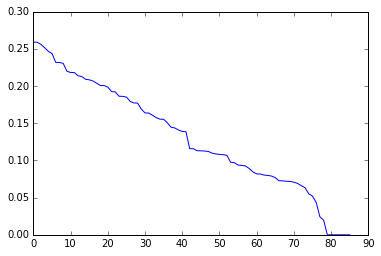

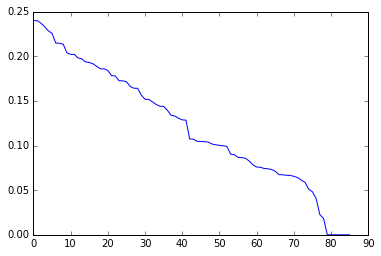

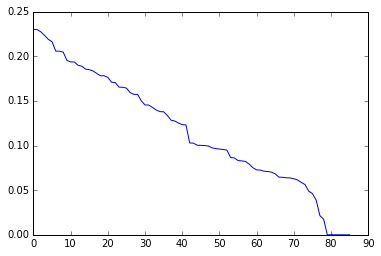

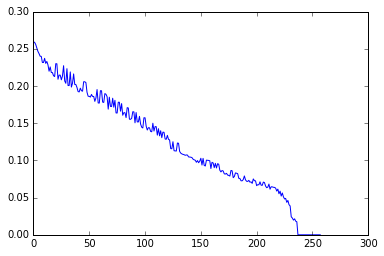

In [104]:
# Sorted difference between min rad and max rad
idx = np.argsort(M[:,AXN-1] / M[:,0])
# q_perp
qp_0 = np.linalg.norm(g0[:,None]*gdir[0][:,:2], axis=1)
idx0 = np.argsort(M[:len(g[0]),AXN-1] / M[:len(g[0]),0] )
pl.figure()
pl.plot(qp_0[idx0])
qp_1 = np.linalg.norm(g1[:,None]*gdir[1][:,:2], axis=1)
idx1 = np.argsort(M[len(g[0]):2*len(g[0]),AXN-1] / M[len(g[0]):2*len(g[0]),0])
pl.figure()
pl.plot(qp_1[idx1])
qp_2 = np.linalg.norm(g2[:,None]*gdir[2][:,:2], axis=1)
idx2 = np.argsort(M[2*len(g[0]):,AXN-1] / M[2*len(g[0]):,0])
pl.figure()
pl.plot(qp_2[idx2])

qp = np.concatenate((qp_0,qp_1,qp_2))
# should also be somewhat monotonic as q_perp is the major contribution to signal decay
pl.figure()
pl.plot(qp[idx])
pl.show()


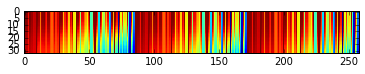

In [105]:
pl.imshow(M.T,interpolation='nearest')
pl.show()

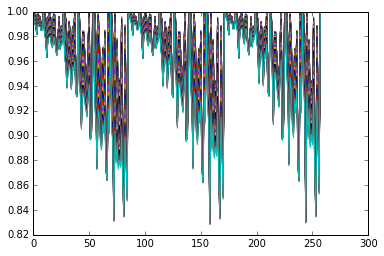

In [106]:
pl.plot(M)
pl.show()

70
[0.99921244 0.03964415 0.00167242]
(0.009, 0.016, 0.259)


[]

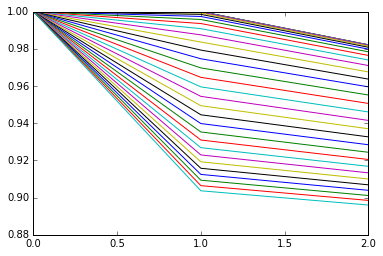

In [109]:
ii = np.argsort(M[:,0] - M[:,AXN-1])[-1]
print(ii)
print(gdir[divmod(ii,len(g[0]))[0]][divmod(ii,len(g[0]))[1]])
print(sdel[divmod(ii,len(g[0]))[0]], bdel[divmod(ii,len(g[0]))[0]], g[divmod(ii,len(g[0]))[0]][divmod(ii,len(g[0]))[1]])
pl.plot(M[ii-1:ii+2])
pl.plot()

ls_plain: $$\min_x \frac{1}{2}\| Mx - data\|_2^2$$

ls_l2_reg: $$\min_x \frac{1}{2}\| Mx - data\|_2^2 + \lambda \| x \|_2^2$$

ls_l2_grad_reg: $$\min_x \frac{1}{2}\| Mx - data\|_2^2 + \lambda \| \nabla x \|_2^2$$

(ls_l1_reg): $$\min_x \frac{1}{2}\| Mx - data\|_2^2 + \lambda \| x \|_1$$

ls_l1_grad_reg: $$\min_x \frac{1}{2}\| Mx - data\|_2^2 + \lambda \| \nabla x \|_1$$


All problem are subject to: $\vec{0} \le x \le \vec{1}$ and $ \| x \|_1 = 1 $

In [110]:
def l2_data(x, M, data):
    # expects args M and data
    # M is (N,k) (#gradient x #radii)
    # data is (N,)
    return (0.5*(np.dot(M,x)-data)**2)

def l1_reg(x):
    return np.abs(x).sum()

def l2_reg(x):
    return (x**2).sum()

def l2_grad_reg(x):
    N = len(x)
    # diagonal of 1's, first subdiagonal of -1's
    R = np.concatenate((np.concatenate((np.zeros((1,N-1)),-np.eye(N-1))),np.zeros((N,1))),axis=1)+np.eye(N)
    return (np.dot(R,x)**2).sum()

def l1_grad_reg(x):
    N = len(x)
    # diagonal of 1's, first subdiagonal of -1's
    R = np.concatenate((np.concatenate((np.zeros((1,N-1)),-np.eye(N-1))),np.zeros((N,1))),axis=1)+np.eye(N)
    return np.abs(np.dot(R,x)).sum()
    
    
def ls_plain(x, M, data, lreg):
    # expects args M and data
    # M is (N,k) (#gradient x #radii)
    # data is (N,)
    # lreg is unused in the plain fit
    return ls_func(x, M, data).sum()

def ls_l2_reg(x, M, data, lreg):
    return ls_func(x, M, data).sum() + lreg*l2_reg(x)

def ls_l1_reg(x, M, data, lreg):
    return ls_func(x, M, data).sum() + lreg*l1_reg(x)

def ls_l2_grad_reg(x, M, data, lreg):
    return ls_func(x, M, data).sum() + lreg*l2_grad_reg(x)

def ls_l1_grad_reg(x, M, data, lreg):
    # ~ TV
    return ls_func(x, M, data).sum() + lreg*l1_grad_reg(x)

In [198]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from scipy.optimize import BFGS

# 0 <= x_i <= 1
bounds = Bounds(np.zeros(len(possible_radii)), np.ones(len(possible_radii)))

# sum(x_i) = 1
# 1 <= [1 1 ... 1] [x_0 x_1 ... x_k]^T <= 1
linear_constraint = LinearConstraint(np.ones(len(possible_radii)), 1, 1)

def fit_func(func, x0, bounds, linCons, *args):
    res = minimize(func, x0, args = args, method='trust-constr', jac='2-point', hess=BFGS(), 
                   constraints=[linCons], options={'verbose': 1}, bounds=bounds, tol=1e-14)
    return res

In [179]:
minimize?

In [180]:
# 3 inital x to test initial condition sensitivity
x0 = []
# flat
x0.append(np.ones(AXN)/float(AXN))
# peak at low rad
tmp = np.zeros(AXN)
tmp[0] = 1
x0.append(tmp)
# peak at mid rad
tmp = np.zeros(AXN)
tmp[AXN//2] = 1
x0.append(tmp)

In [181]:
# the signal generation function takes in fraction on number of axon, not fraction of signal
# the fitting procedure fit signal fractions (because M is build that way)
def gendata_N(rs, ws):
    tmp = np.zeros((0))
    for acq in range(len(g)):
        tmp = np.concatenate((tmp, E_restricted_distri(gdir[acq]*g[acq][:,None], Dfree, sdel[acq], bdel[acq], rs, ws)))

In [182]:
# this signal generation function convert an input of signal weight into number of axon weight for the function call
def gendata_S(rs, ws):
    ws = ws/rs**2
    ws = ws / np.sum(ws)
    tmp = np.zeros((0))
    for acq in range(len(g)):
        tmp = np.concatenate((tmp, E_restricted_distri(gdir[acq]*g[acq][:,None], Dfree, sdel[acq], bdel[acq], rs, ws)))
    return tmp

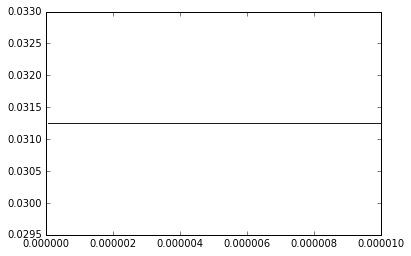

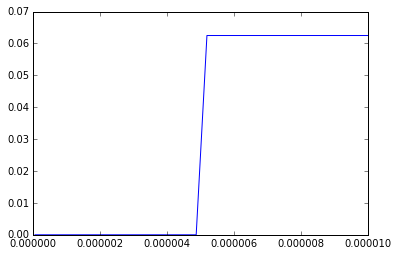

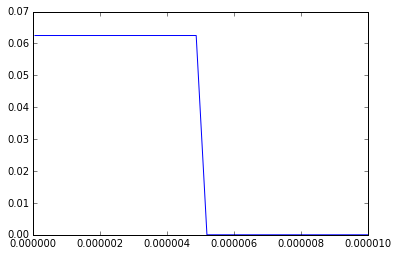

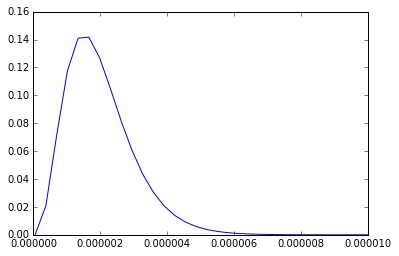

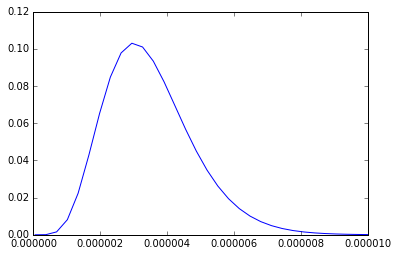

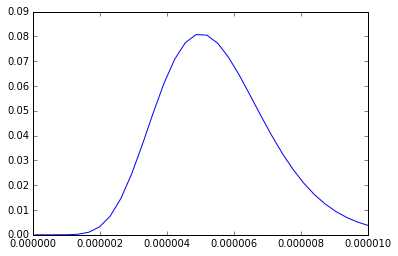

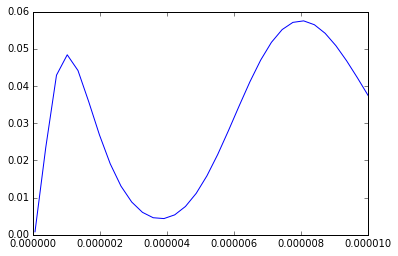

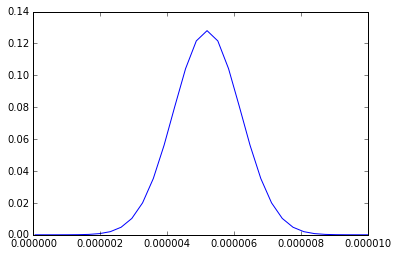

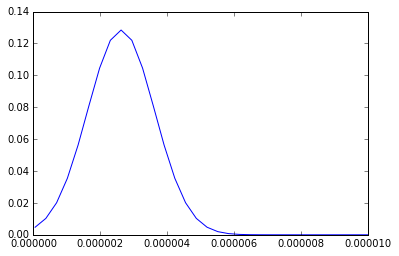

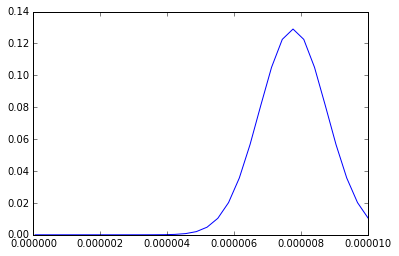

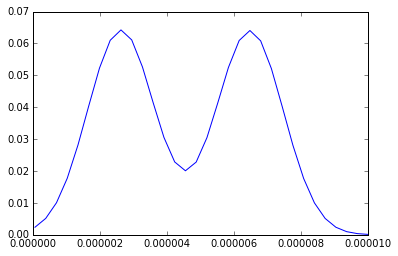

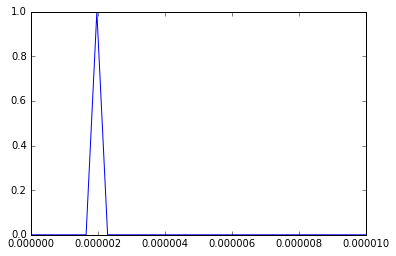

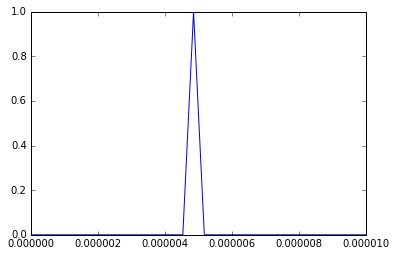

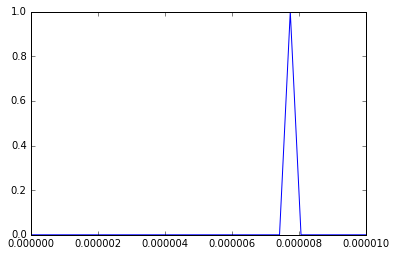

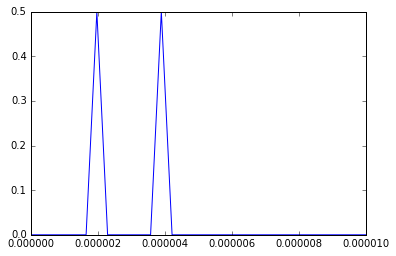

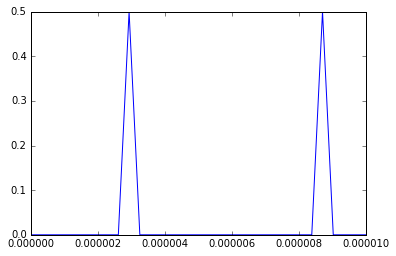

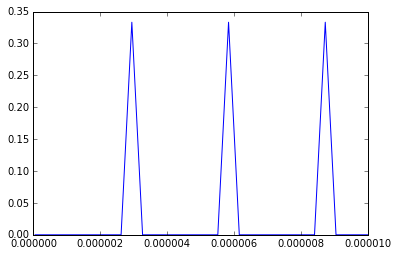

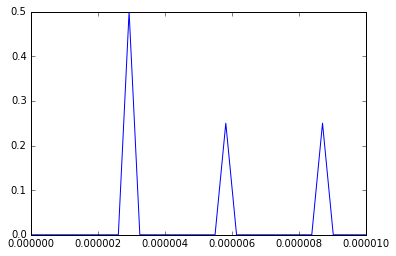

In [183]:
from scipy.stats import gamma, norm
# making a few different types of data
# for simplicity, the datas are all defined on the possible_radii discretization
xs = []
data = []

# flat (signal)
xs.append(np.ones(AXN)/float(AXN))
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# flat high (signal)
tmp = np.zeros(AXN)
tmp[AXN//2:]=1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# flat low (signal)
tmp = np.zeros(AXN)
tmp[:AXN//2]=1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# gamma over diameter (# axon)
tmp = gamma.pdf(possible_diameters, 2., loc = 0, scale = 1e-6)
tmp = tmp * possible_radii**2
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# gamma over diameter (# axon)
tmp = gamma.pdf(possible_diameters, 5., loc = 0, scale = 1e-6)
tmp = tmp * possible_radii**2
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# gamma over diameter (# axon)
tmp = gamma.pdf(possible_diameters, 9., loc = 0, scale = 1e-6)
tmp = tmp * possible_radii**2
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sum 2 gamma over diameter (# axon)
tmp1 = gamma.pdf(possible_diameters, 1, loc = 0, scale = 1e-6)
tmp2 = gamma.pdf(possible_diameters, 15., loc = 0, scale = 1e-6)
tmp = 50*tmp1/tmp1.sum() + tmp2/tmp2.sum() 
tmp = tmp * possible_radii**2
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# gaussian (signal)
tmp = norm.pdf(possible_radii, loc = possible_radii[AXN//2], scale = 1e-6)
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# gaussian (signal)
tmp = norm.pdf(possible_radii, loc = possible_radii[AXN//4], scale = 1e-6)
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# gaussian (signal)
tmp = norm.pdf(possible_radii, loc = possible_radii[3*(AXN//4)], scale = 1e-6)
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sum 2 gaussian (signal)
tmp1 = norm.pdf(possible_radii, loc = possible_radii[int(np.floor(2*(AXN//7)))], scale = 1e-6)
tmp2 = norm.pdf(possible_radii, loc = possible_radii[int(np.floor(5*(AXN//7)))], scale = 1e-6)
tmp = tmp1/tmp1.sum() + tmp2/tmp2.sum() 
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sparse k=1
tmp = np.zeros(AXN)
tmp[int(np.floor(2*(AXN//10)))] = 1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sparse k=1
tmp = np.zeros(AXN)
tmp[int(np.floor(5*(AXN//10)))] = 1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sparse k=1
tmp = np.zeros(AXN)
tmp[int(np.floor(8*(AXN//10)))] = 1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sparse k=2
tmp = np.zeros(AXN)
tmp[int(np.floor(2*(AXN//10)))] = 1
tmp[int(np.floor(4*(AXN//10)))] = 1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sparse k=2
tmp = np.zeros(AXN)
tmp[int(np.floor(3*(AXN//10)))] = 1
tmp[int(np.floor(9*(AXN//10)))] = 1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sparse k=3
tmp = np.zeros(AXN)
tmp[int(np.floor(3*(AXN//10)))] = 1
tmp[int(np.floor(6*(AXN//10)))] = 1
tmp[int(np.floor(9*(AXN//10)))] = 1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])
# sparse k=3
tmp = np.zeros(AXN)
tmp[int(np.floor(3*(AXN//10)))] = 2
tmp[int(np.floor(6*(AXN//10)))] = 1
tmp[int(np.floor(9*(AXN//10)))] = 1
xs.append(tmp/tmp.sum())
data.append(gendata_S(possible_radii, xs[-1]))
pl.figure()
pl.plot(possible_radii,xs[-1])

`gtol` termination condition is satisfied.
Number of iterations: 2, function evaluations: 66, CG iterations: 1, optimality: 2.84e-09, constraint violation: 0.00e+00, execution time: 0.0096 s.
`gtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 825, CG iterations: 365, optimality: 3.45e-09, constraint violation: 4.44e-15, execution time: 0.18 s.
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 1518, CG iterations: 879, optimality: 9.90e-09, constraint violation: 5.33e-15, execution time: 0.37 s.
`gtol` termination condition is satisfied.
Number of iterations: 197, function evaluations: 6204, CG iterations: 5389, optimality: 6.84e-09, constraint violation: 2.33e-15, execution time:  1.8 s.
`gtol` termination condition is satisfied.
Number of iterations: 264, function evaluations: 8415, CG iterations: 7292, optimality: 9.51e-09, constraint violation: 1.69e-14, execution time:  2.1 s.
`gtol` termination condit

`gtol` termination condition is satisfied.
Number of iterations: 56, function evaluations: 1551, CG iterations: 1050, optimality: 5.78e-09, constraint violation: 0.00e+00, execution time: 0.42 s.
`gtol` termination condition is satisfied.
Number of iterations: 105, function evaluations: 3168, CG iterations: 2341, optimality: 9.55e-09, constraint violation: 1.33e-15, execution time: 0.83 s.
`gtol` termination condition is satisfied.
Number of iterations: 46, function evaluations: 1254, CG iterations: 572, optimality: 9.25e-09, constraint violation: 8.88e-16, execution time: 0.26 s.
`gtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 792, CG iterations: 357, optimality: 1.95e-09, constraint violation: 3.11e-15, execution time: 0.17 s.
`gtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 1452, CG iterations: 752, optimality: 5.22e-09, constraint violation: 1.11e-15, execution time: 0.32 s.
`gtol` termination cond

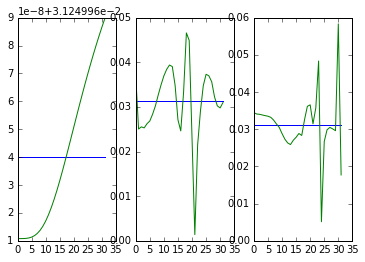

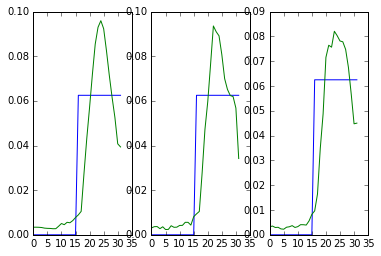

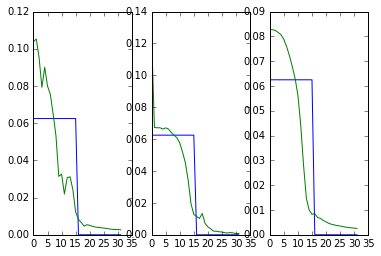

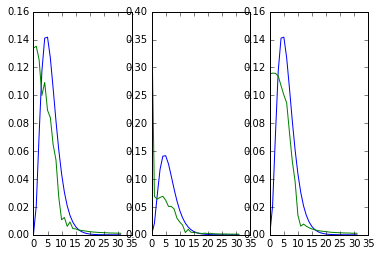

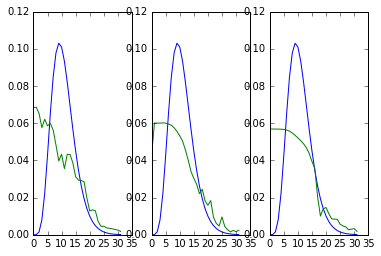

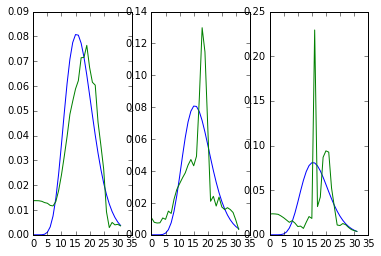

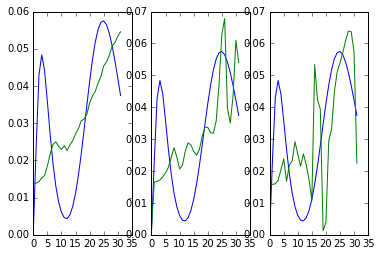

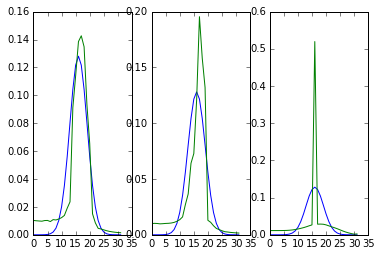

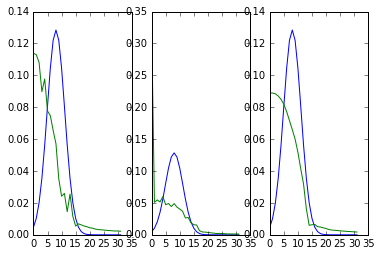

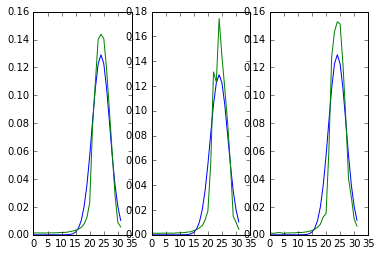

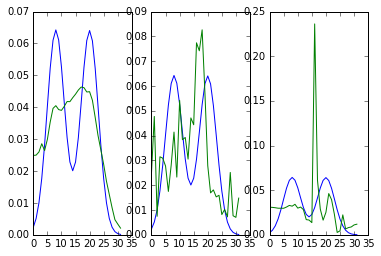

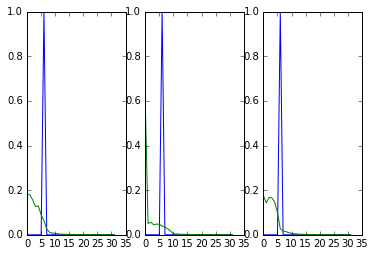

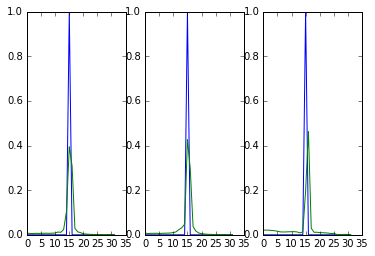

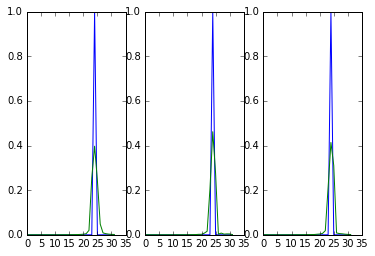

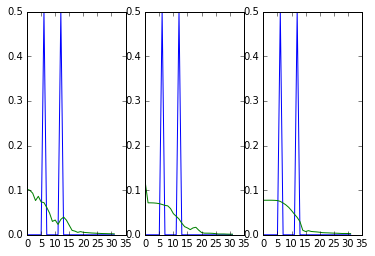

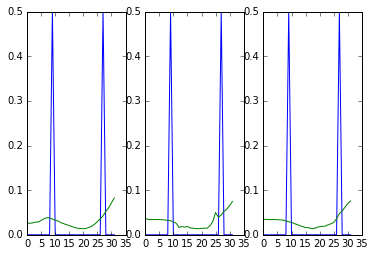

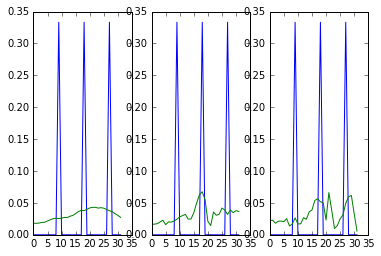

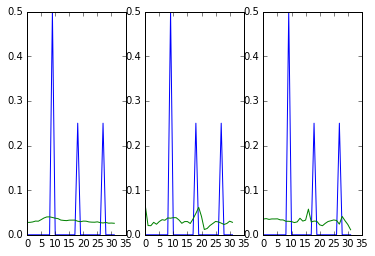

In [197]:
opt = ls_plain
res_ls_plain = []
lreg = 0.0
for idata in range(len(data)):
    pl.figure()
    for iinit in range(len(x0)):
        res = fit_func(opt, x0[iinit], bounds, linear_constraint, M, data[idata], lreg)
        res_ls_plain.append(res)
        pl.subplot(1,len(x0),iinit+1)
        pl.plot(xs[idata])
        pl.plot(res.x)

`xtol` termination condition is satisfied.
Number of iterations: 482, function evaluations: 20163, CG iterations: 4491, optimality: 4.09e-11, constraint violation: 0.00e+00, execution time:  2.6 s.
`xtol` termination condition is satisfied.
Number of iterations: 432, function evaluations: 17655, CG iterations: 4323, optimality: 1.86e-11, constraint violation: 0.00e+00, execution time:  2.6 s.
`xtol` termination condition is satisfied.
Number of iterations: 447, function evaluations: 18678, CG iterations: 3958, optimality: 3.49e-11, constraint violation: 0.00e+00, execution time:  2.7 s.
`xtol` termination condition is satisfied.
Number of iterations: 253, function evaluations: 9108, CG iterations: 1778, optimality: 1.74e-12, constraint violation: 0.00e+00, execution time:  1.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 282, function evaluations: 11946, CG iterations: 2448, optimality: 9.19e-12, constraint violation: 0.00e+00, execution time:  1.7 s.
`xtol` term

`xtol` termination condition is satisfied.
Number of iterations: 517, function evaluations: 22440, CG iterations: 4908, optimality: 1.17e-11, constraint violation: 0.00e+00, execution time:  3.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 680, function evaluations: 28182, CG iterations: 10976, optimality: 1.92e-11, constraint violation: 0.00e+00, execution time:  5.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 302, function evaluations: 13794, CG iterations: 3138, optimality: 1.66e-11, constraint violation: 0.00e+00, execution time:  1.8 s.
`xtol` termination condition is satisfied.
Number of iterations: 235, function evaluations: 11055, CG iterations: 2039, optimality: 5.72e-12, constraint violation: 0.00e+00, execution time:  1.2 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 32637, CG iterations: 25403, optimality: 2.89e-10, constraint violation: 2.22e-16, execution time:  7

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 34155, CG iterations: 15849, optimality: 8.15e-10, constraint violation: 0.00e+00, execution time:  6.1 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 32736, CG iterations: 13391, optimality: 2.07e-09, constraint violation: 0.00e+00, execution time:  5.7 s.
`xtol` termination condition is satisfied.
Number of iterations: 871, function evaluations: 30690, CG iterations: 13892, optimality: 1.32e-11, constraint violation: 0.00e+00, execution time:  5.2 s.
`xtol` termination condition is satisfied.
Number of iterations: 251, function evaluations: 8547, CG iterations: 2243, optimality: 7.55e-12, constraint violation: 0.00e+00, execution time:  1.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 292, function evaluations: 10626, CG iterations: 2776, optimality: 7.63e-12, constraint violation: 0.00e+00, exec

`xtol` termination condition is satisfied.
Number of iterations: 355, function evaluations: 15906, CG iterations: 3543, optimality: 1.49e-11, constraint violation: 0.00e+00, execution time:  2.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 438, function evaluations: 19338, CG iterations: 5239, optimality: 1.36e-11, constraint violation: 0.00e+00, execution time:  2.4 s.
`xtol` termination condition is satisfied.
Number of iterations: 994, function evaluations: 38280, CG iterations: 16512, optimality: 2.43e-11, constraint violation: 0.00e+00, execution time:  6.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 223, function evaluations: 10230, CG iterations: 1994, optimality: 1.09e-11, constraint violation: 0.00e+00, execution time:  1.2 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 32670, CG iterations: 21713, optimality: 5.37e-10, constraint violation: 0.00e+00, execution time:  7

The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 32670, CG iterations: 21611, optimality: 3.48e-09, constraint violation: 9.99e-16, execution time:  7.3 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 32670, CG iterations: 28579, optimality: 4.03e-10, constraint violation: 0.00e+00, execution time:  8.3 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 33363, CG iterations: 18849, optimality: 3.55e-11, constraint violation: 1.78e-15, execution time:  6.6 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 33066, CG iterations: 12843, optimality: 5.53e-11, constraint violation: 7.99e-15, execution time:  5.5 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 32604, CG iterations: 18127, optimality: 3

`xtol` termination condition is satisfied.
Number of iterations: 325, function evaluations: 13299, CG iterations: 3009, optimality: 9.45e-12, constraint violation: 0.00e+00, execution time:  1.6 s.
`xtol` termination condition is satisfied.
Number of iterations: 257, function evaluations: 9735, CG iterations: 2330, optimality: 7.17e-12, constraint violation: 0.00e+00, execution time:  1.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 253, function evaluations: 8745, CG iterations: 2109, optimality: 6.79e-13, constraint violation: 0.00e+00, execution time:  1.4 s.
`xtol` termination condition is satisfied.
Number of iterations: 283, function evaluations: 10923, CG iterations: 2100, optimality: 1.74e-11, constraint violation: 0.00e+00, execution time:  1.6 s.
`xtol` termination condition is satisfied.
Number of iterations: 255, function evaluations: 10263, CG iterations: 2088, optimality: 4.75e-12, constraint violation: 0.00e+00, execution time:  1.5 s.
`xtol` termi

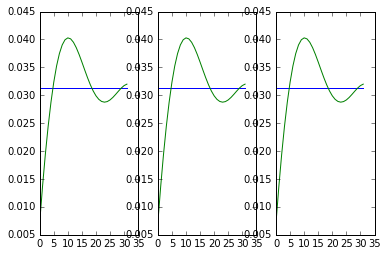

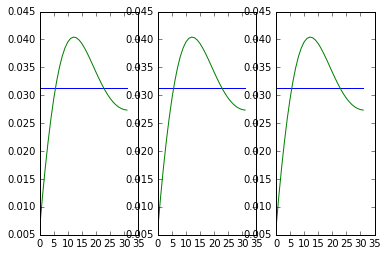

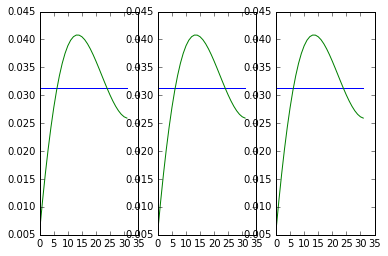

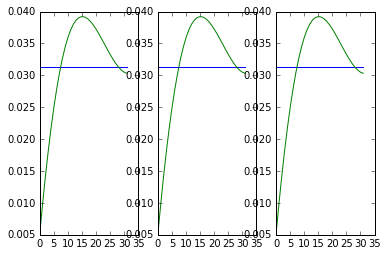

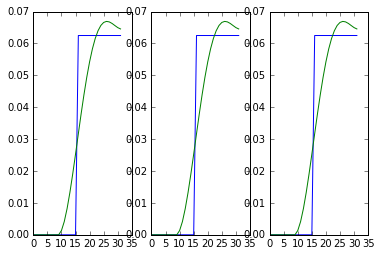

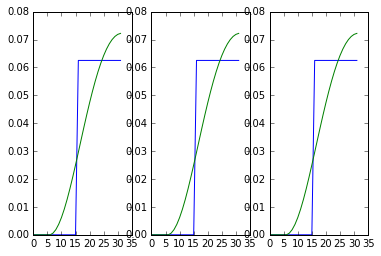

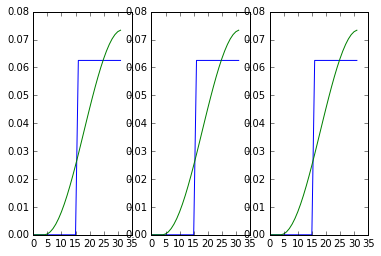

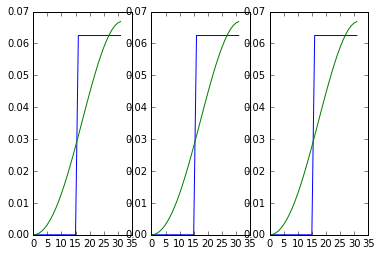

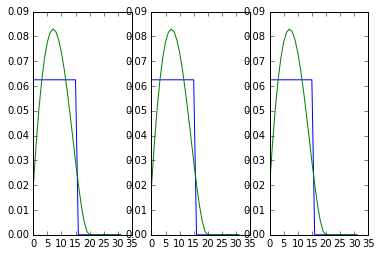

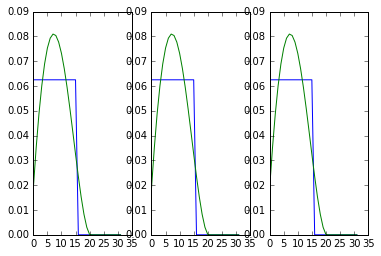

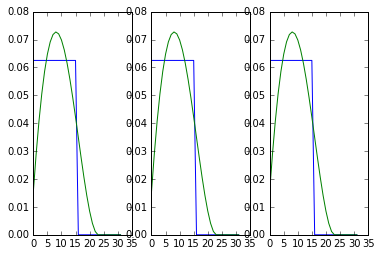

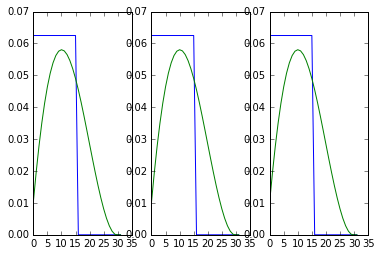

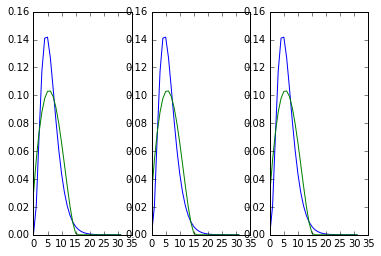

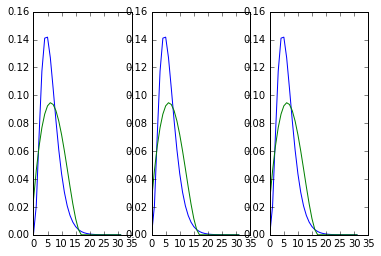

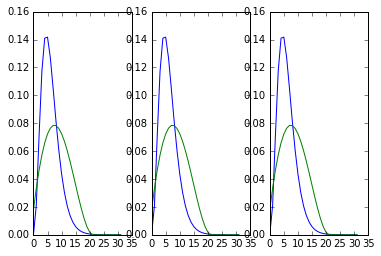

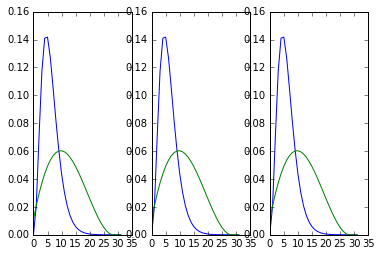

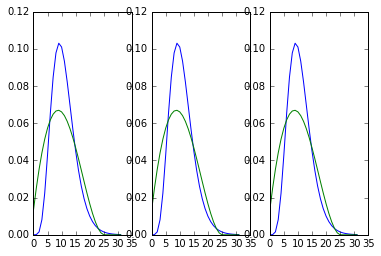

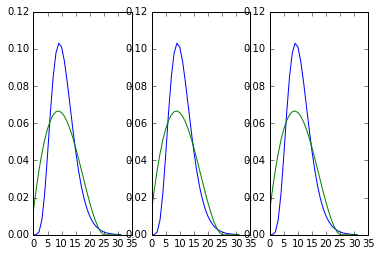

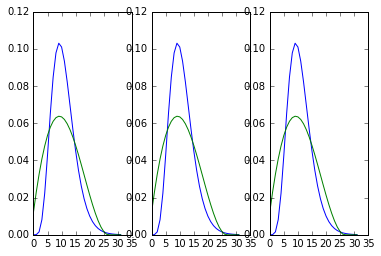

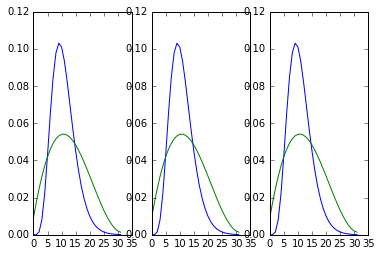

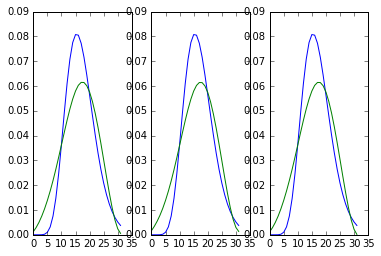

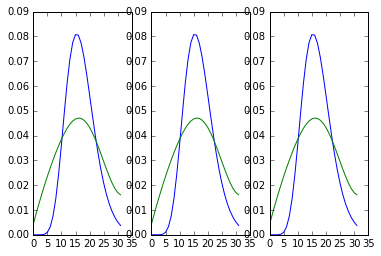

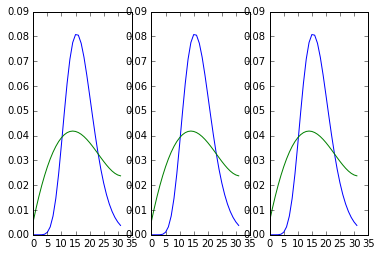

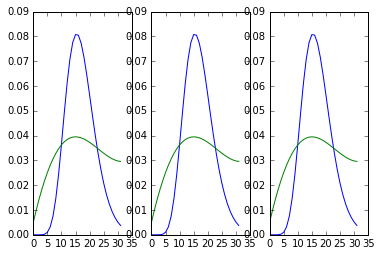

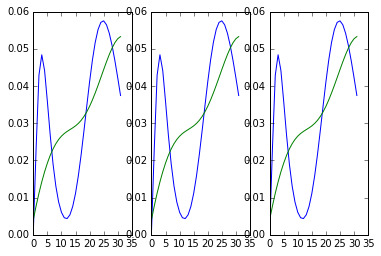

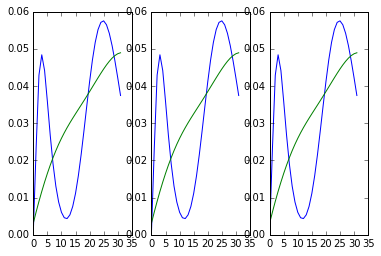

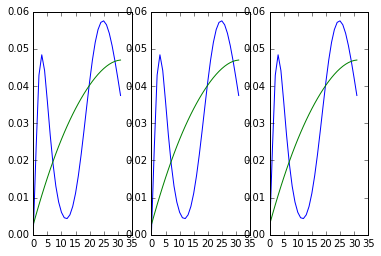

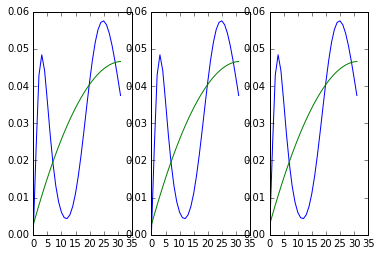

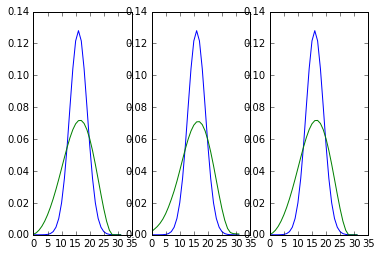

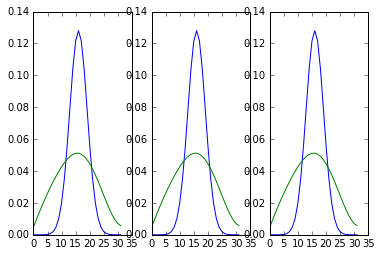

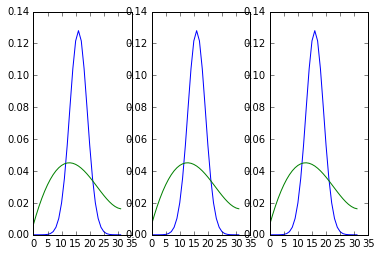

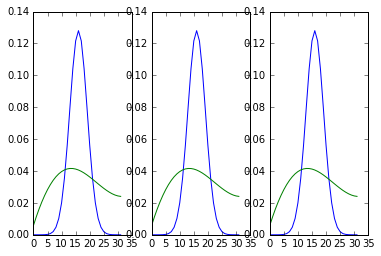

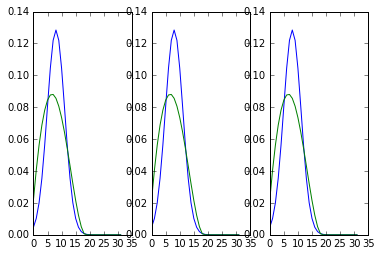

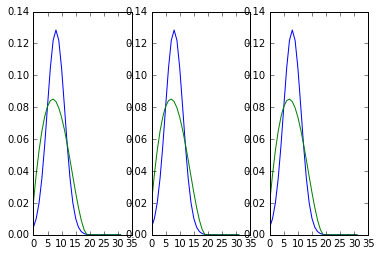

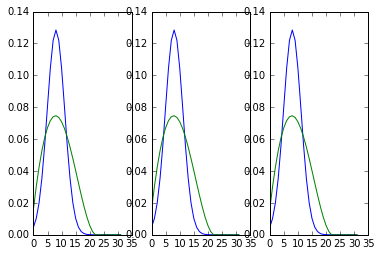

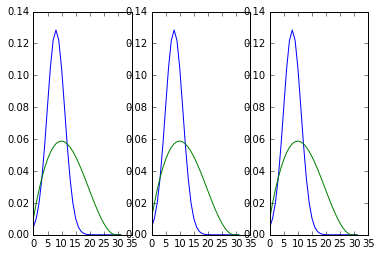

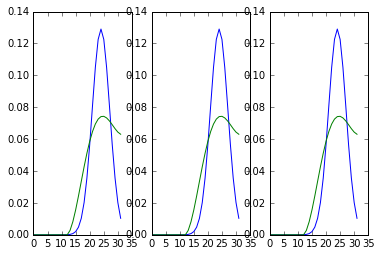

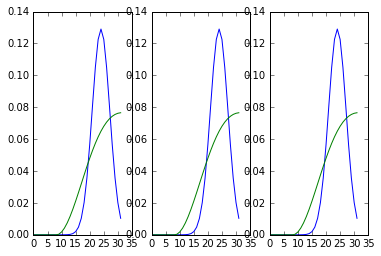

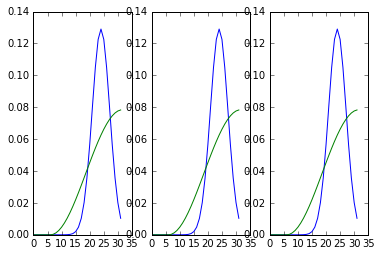

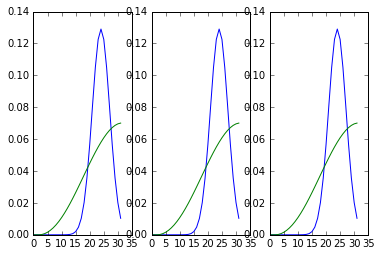

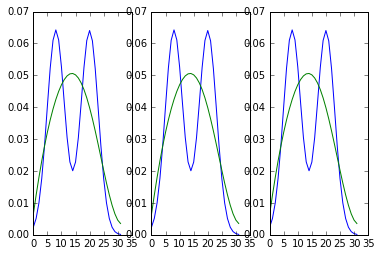

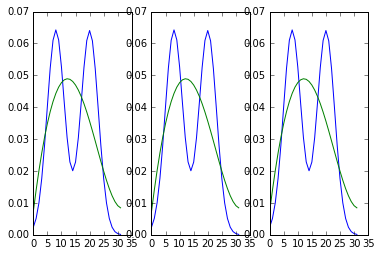

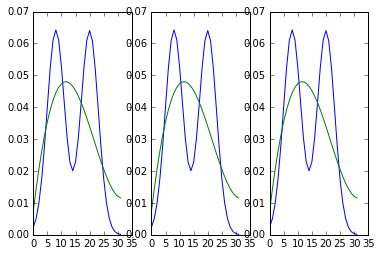

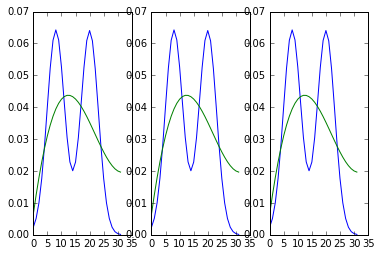

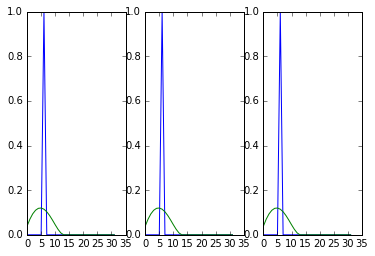

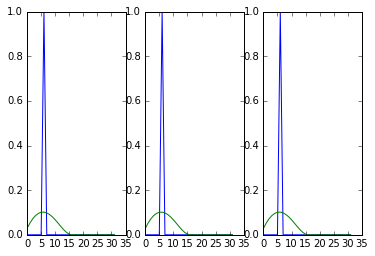

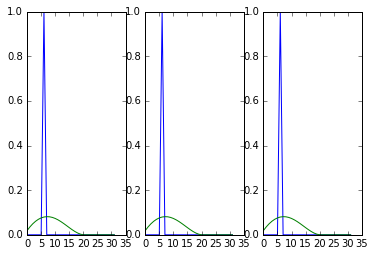

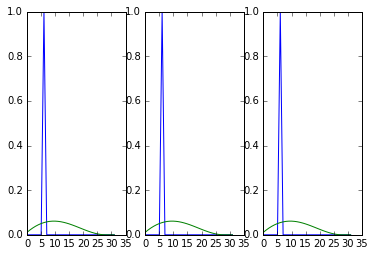

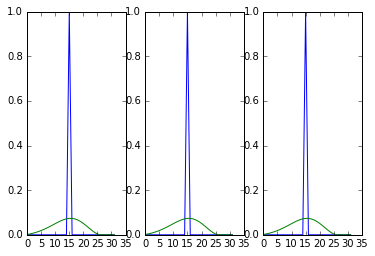

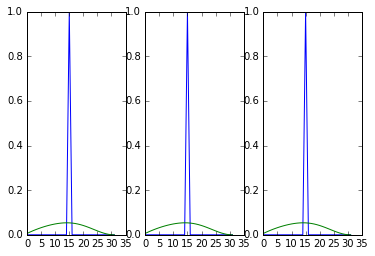

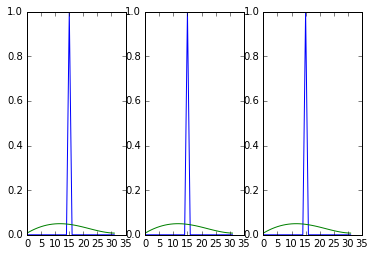

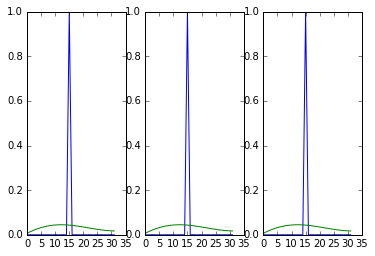

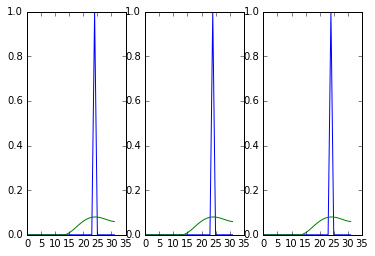

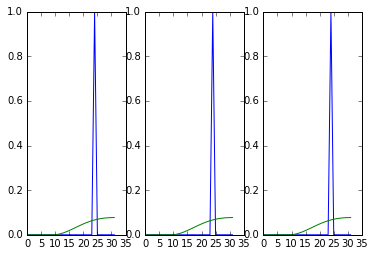

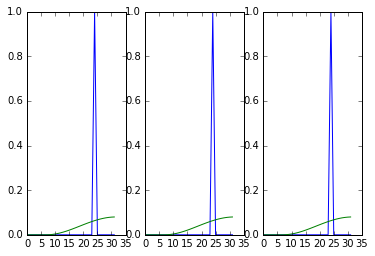

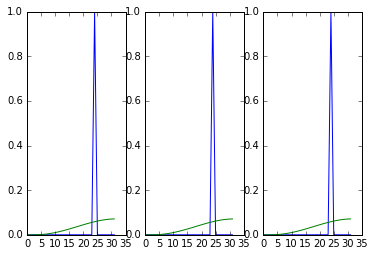

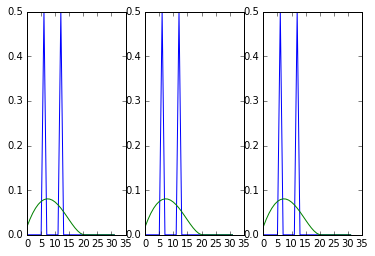

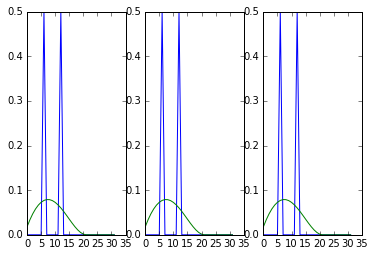

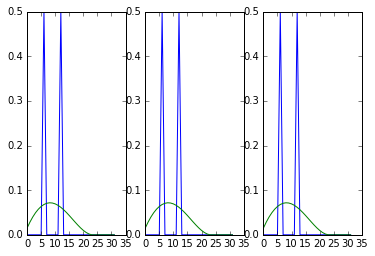

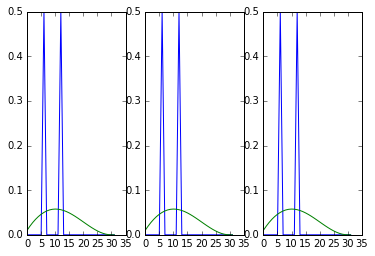

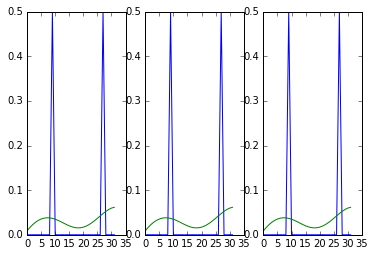

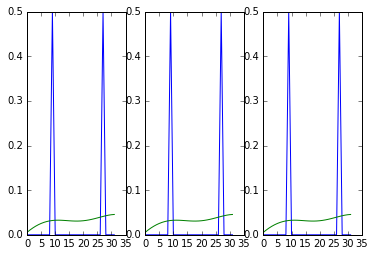

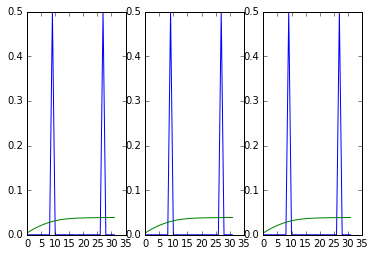

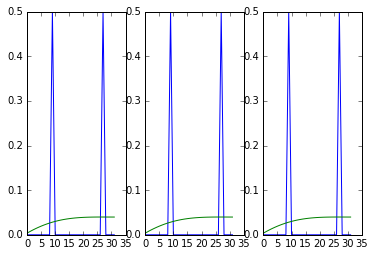

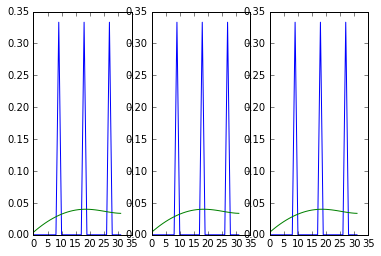

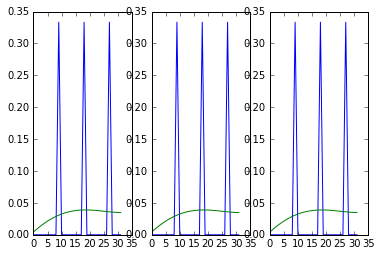

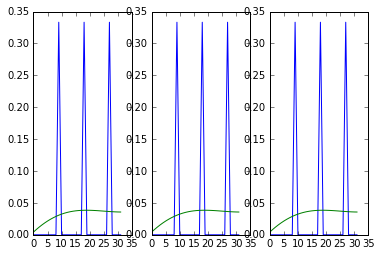

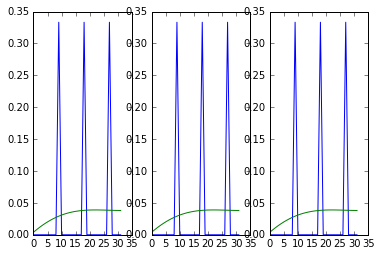

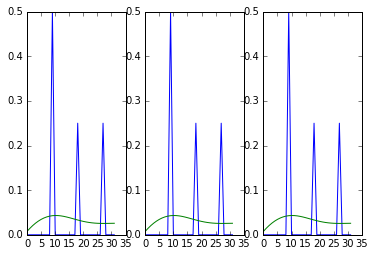

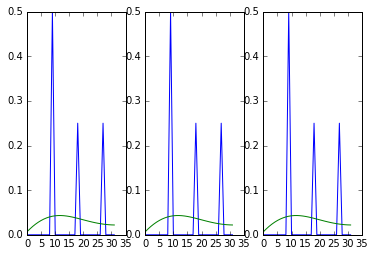

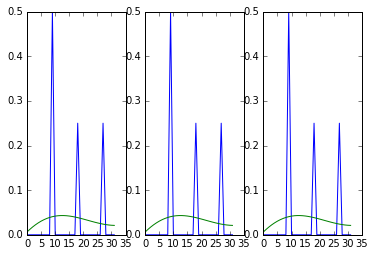

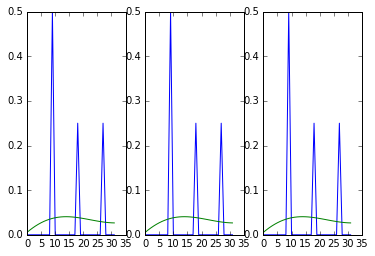

In [199]:
opt = ls_l2_grad_reg
res_ls_l2_grad = []
lreg = 0.1
for idata in range(len(data)):
    for lreg in [1e-2, 1e-1, 1, 1e1]:
        pl.figure()
        pl.title(lreg)
        for iinit in range(len(x0)):
            res = fit_func(opt, x0[iinit], bounds, linear_constraint, M, data[idata], lreg)
            res_ls_l2_grad.append(res)
            pl.subplot(1,len(x0),iinit+1)
            pl.plot(xs[idata])
            pl.plot(res.x)

`xtol` termination condition is satisfied.
Number of iterations: 718, function evaluations: 29601, CG iterations: 10255, optimality: 4.78e-11, constraint violation: 0.00e+00, execution time:  5.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 669, function evaluations: 27885, CG iterations: 7214, optimality: 2.91e-11, constraint violation: 0.00e+00, execution time:  4.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 380, function evaluations: 15477, CG iterations: 2781, optimality: 4.93e-11, constraint violation: 0.00e+00, execution time:  1.8 s.
`xtol` termination condition is satisfied.
Number of iterations: 295, function evaluations: 11880, CG iterations: 2413, optimality: 1.98e-11, constraint violation: 0.00e+00, execution time:  1.4 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 33495, CG iterations: 27917, optimality: 4.70e-10, constraint violation: 2.22e-16, execution time:  8

The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 38280, CG iterations: 18854, optimality: 9.24e-11, constraint violation: 3.33e-16, execution time:  8.9 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 38412, CG iterations: 18118, optimality: 1.67e-10, constraint violation: 2.22e-16, execution time:  8.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 477, function evaluations: 18975, CG iterations: 5561, optimality: 2.54e-11, constraint violation: 0.00e+00, execution time:  2.9 s.
`xtol` termination condition is satisfied.
Number of iterations: 354, function evaluations: 13101, CG iterations: 4286, optimality: 1.92e-12, constraint violation: 0.00e+00, execution time:  2.6 s.
`xtol` termination condition is satisfied.
Number of iterations: 340, function evaluations: 14025, CG iterations: 3617, optimality: 1.37e-11, constraint violation: 0.00e+00, exec

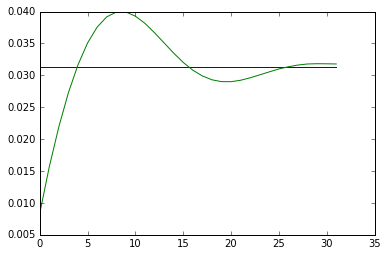

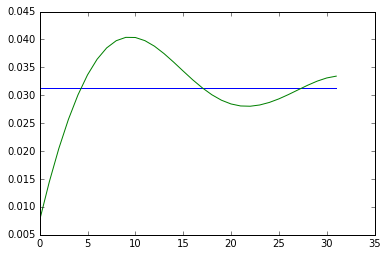

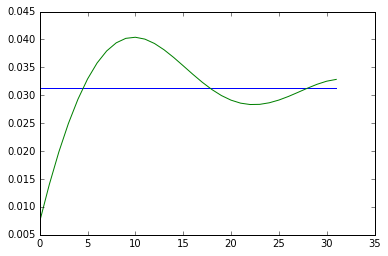

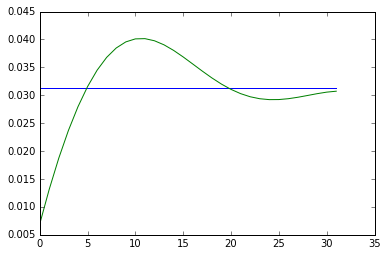

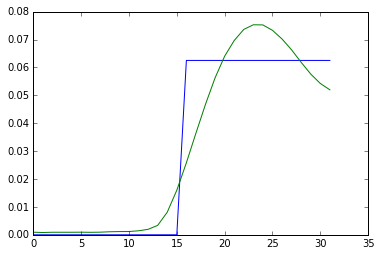

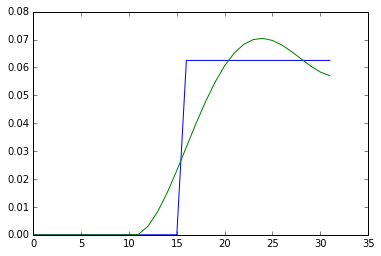

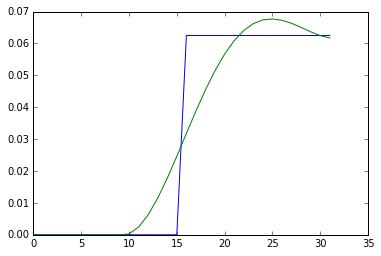

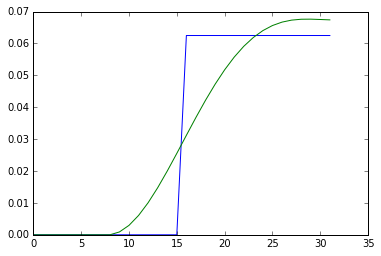

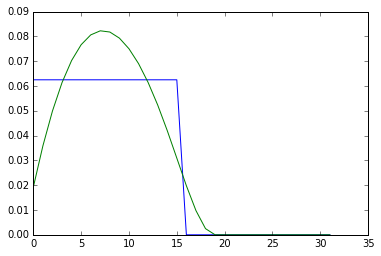

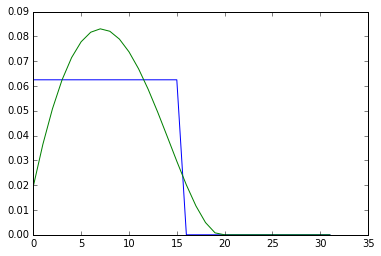

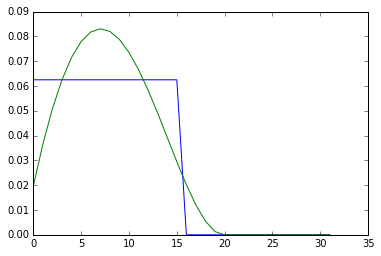

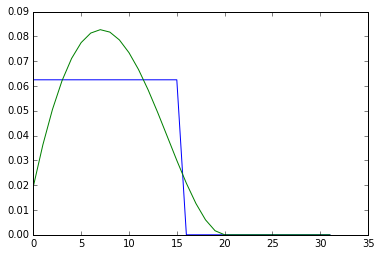

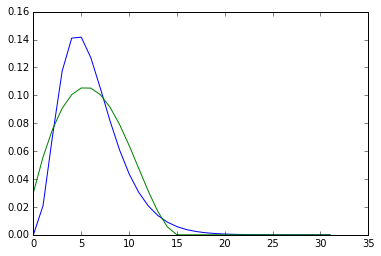

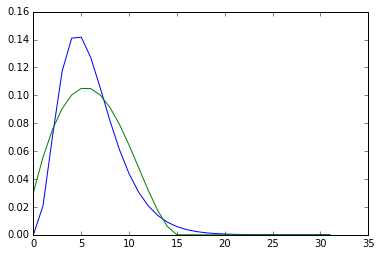

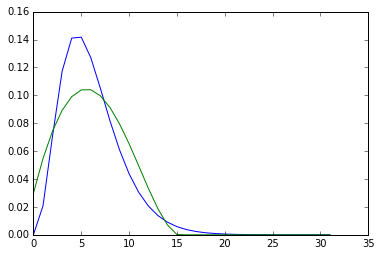

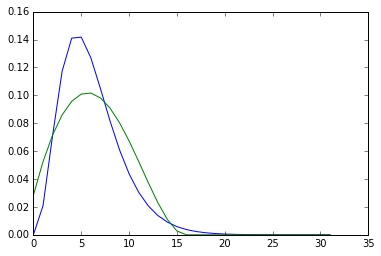

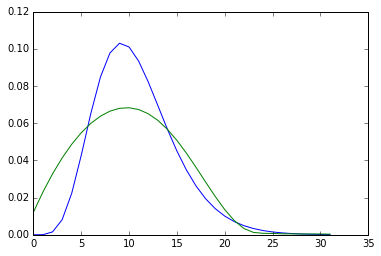

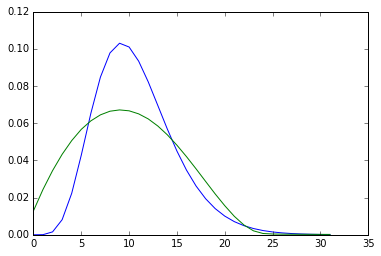

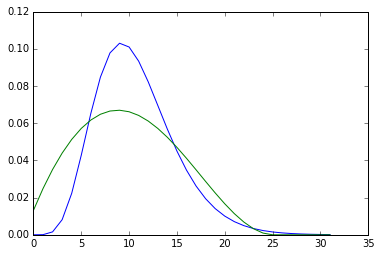

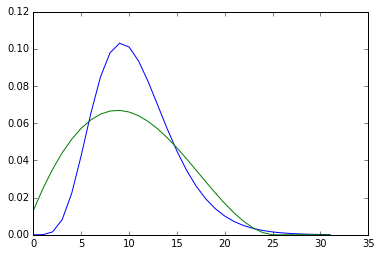

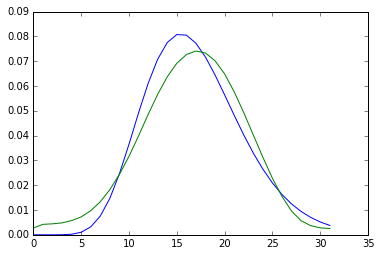

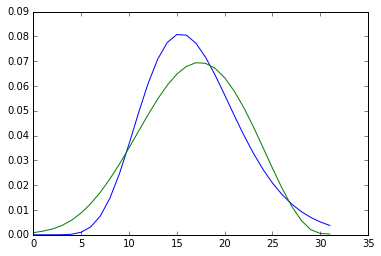

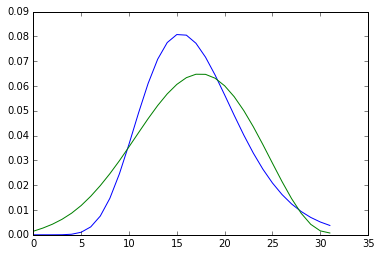

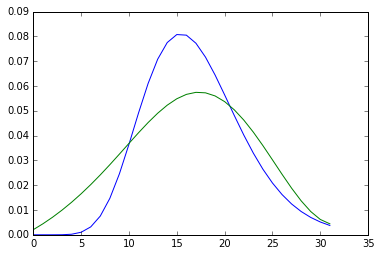

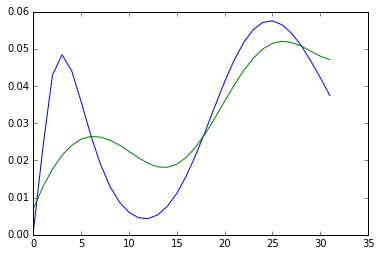

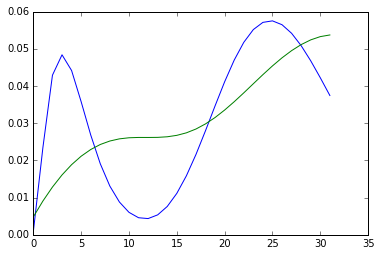

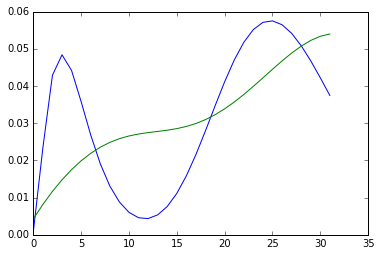

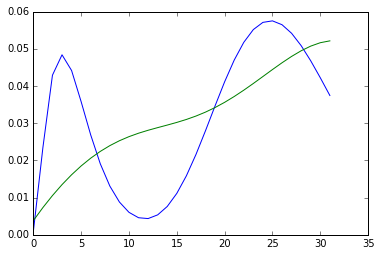

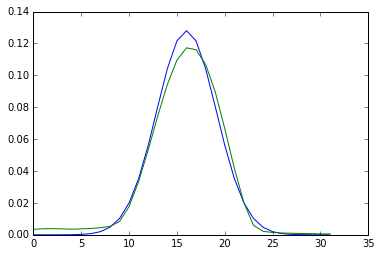

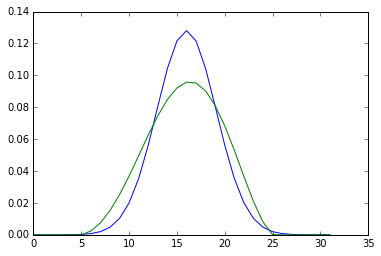

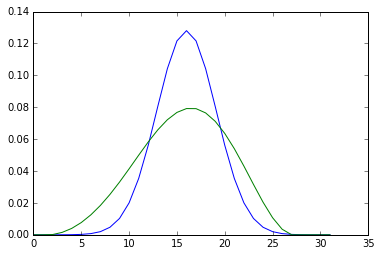

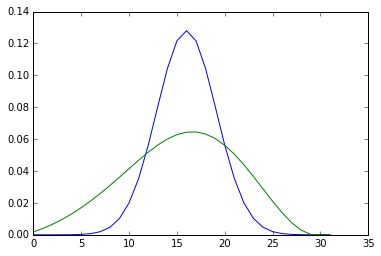

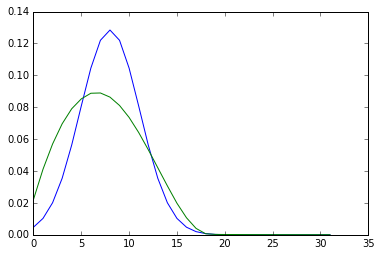

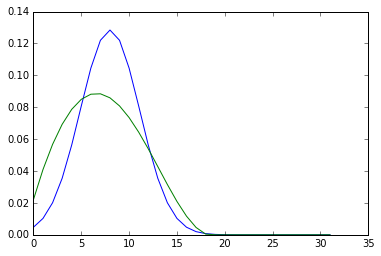

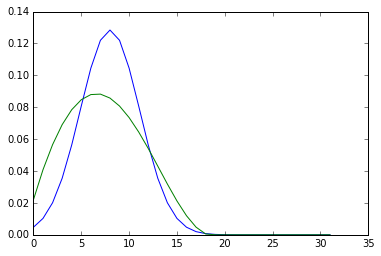

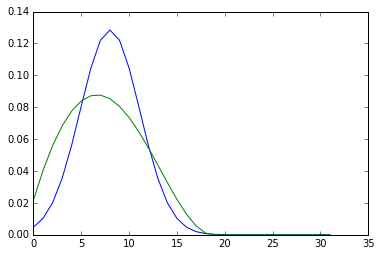

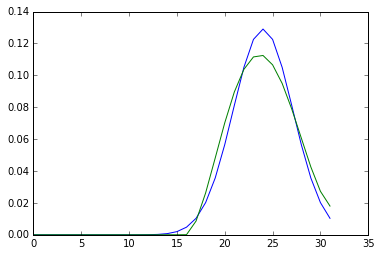

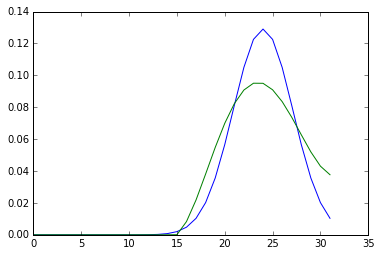

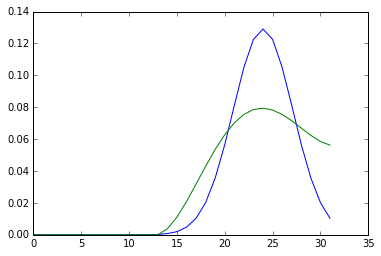

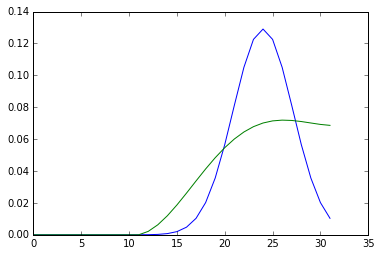

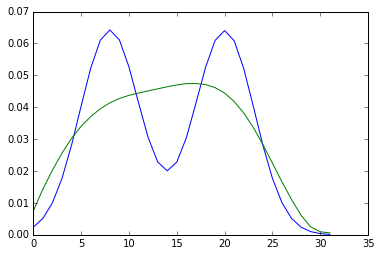

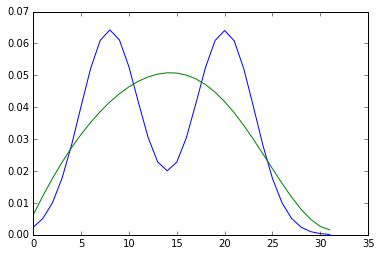

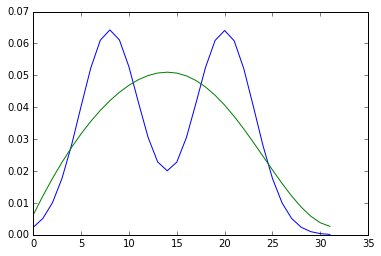

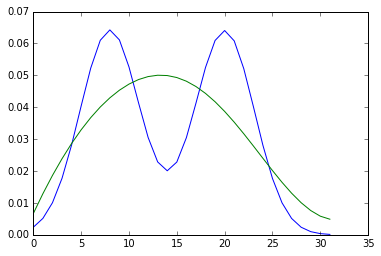

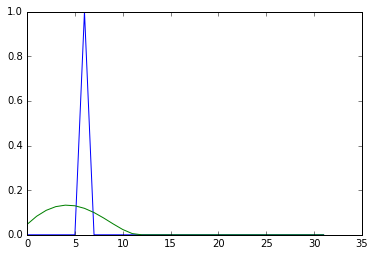

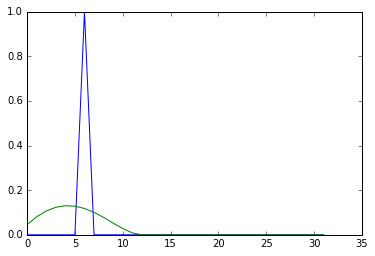

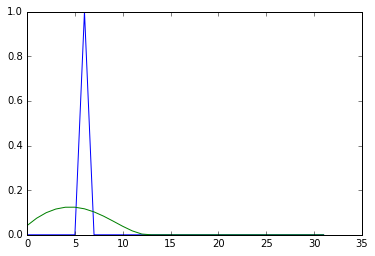

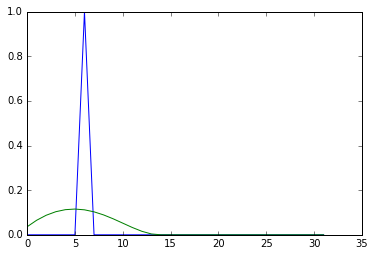

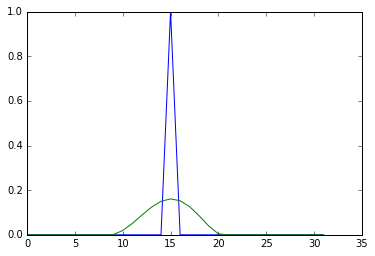

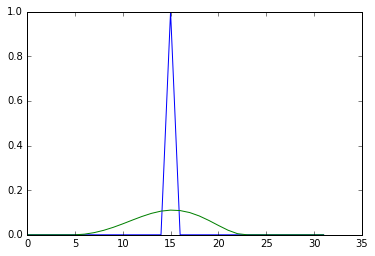

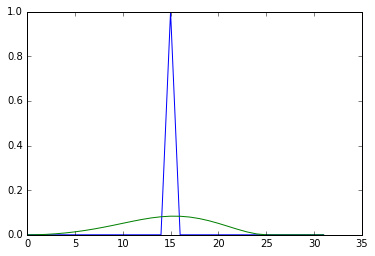

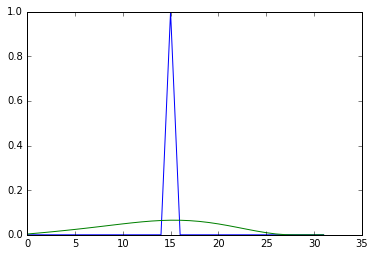

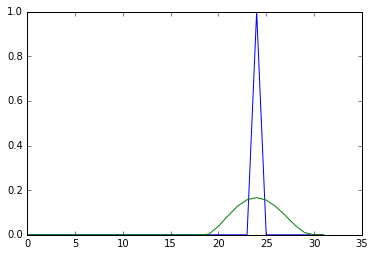

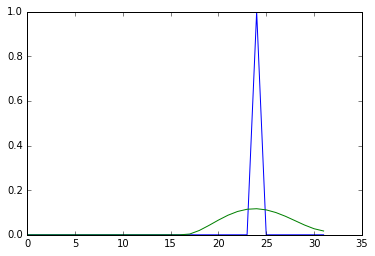

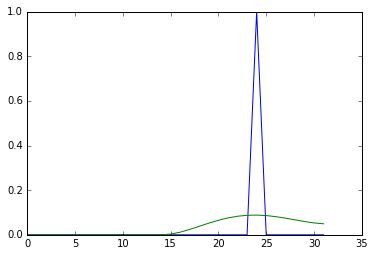

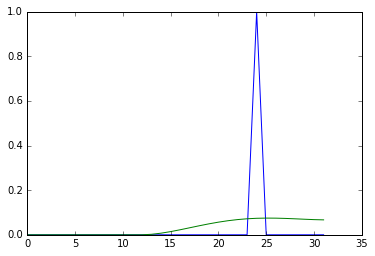

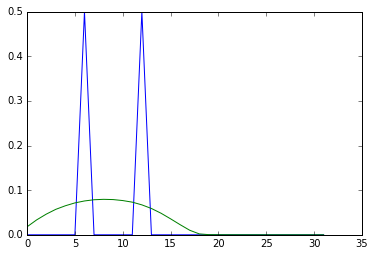

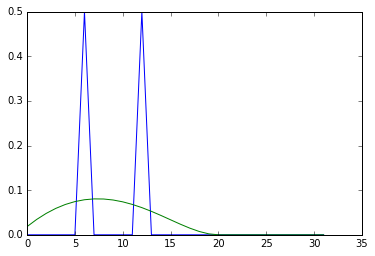

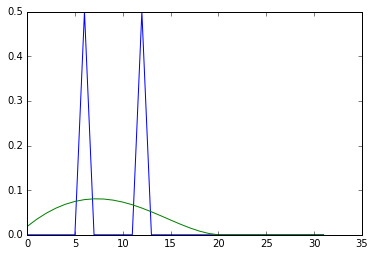

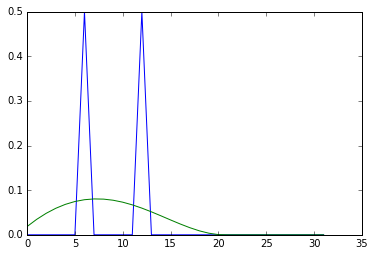

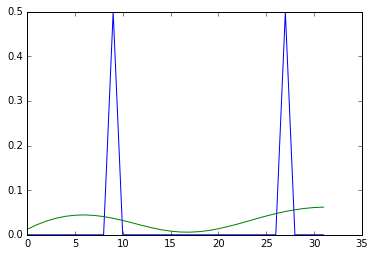

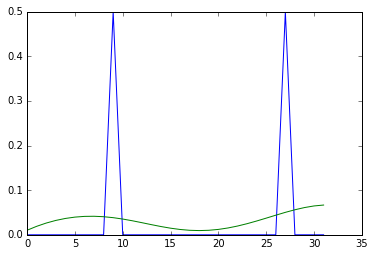

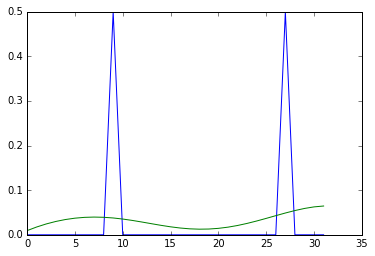

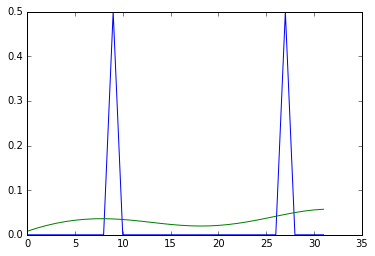

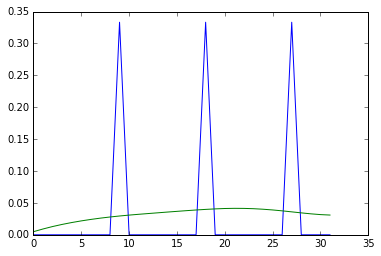

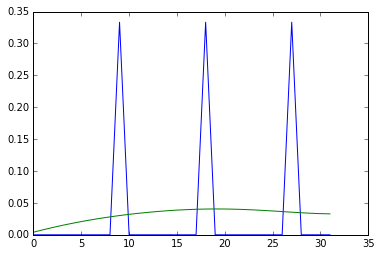

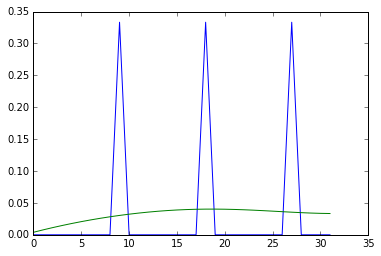

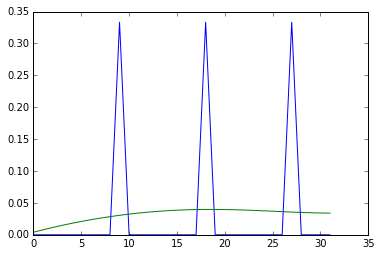

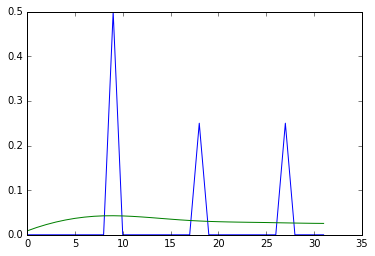

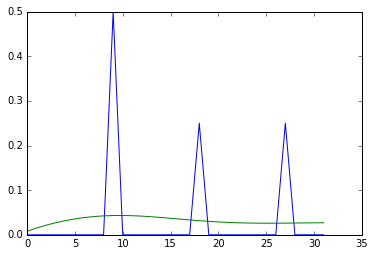

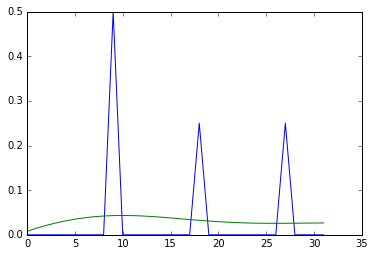

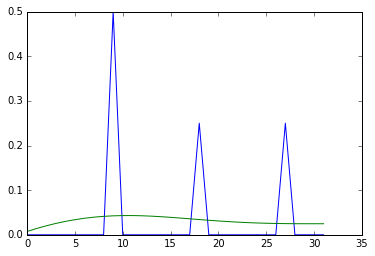

In [202]:
opt = ls_l2_grad_reg
res2_ls_l2_grad = []
lreg = 0.1
for idata in range(len(data)):
    for lreg in [1e-4, 1e-3, 5e-3, 2e-2]:
        pl.figure()
        for iinit in range(1):
            res = fit_func(opt, x0[iinit], bounds, linear_constraint, M, data[idata], lreg)
            res_ls_l2_grad.append(res)
            pl.subplot(1,1,iinit+1)
            pl.plot(xs[idata])
            pl.plot(res.x)

In [ ]:
opt = ls_l2_grad_reg
res2_ls_l2_grad = []
lreg = 0.1
for idata in range(len(data)):
    for lreg in [1e-6, 1e-5]:
        pl.figure()
        for iinit in range(1):
            res = fit_func(opt, x0[iinit], bounds, linear_constraint, M, data[idata], lreg)
            res_ls_l2_grad.append(res)
            pl.subplot(1,1,iinit+1)
            pl.plot(xs[idata])
            pl.plot(res.x)

`xtol` termination condition is satisfied.
Number of iterations: 700, function evaluations: 24981, CG iterations: 15117, optimality: 4.67e-11, constraint violation: 0.00e+00, execution time:  5.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 719, function evaluations: 26103, CG iterations: 14775, optimality: 2.05e-11, constraint violation: 0.00e+00, execution time:  4.9 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 34683, CG iterations: 26629, optimality: 5.48e-11, constraint violation: 1.55e-14, execution time:  7.9 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 32769, CG iterations: 29624, optimality: 2.94e-10, constraint violation: 4.44e-16, execution time: 1e+01 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 36003, CG iterations: 22063, optimality: 4.56e-11, constraint violati

In [84]:
funcopt = [ls_plain, ls_l2_reg, ls_l1_reg, ls_l2_grad_reg, ls_l1_grad_reg]
x0 = np.ones(32)/32
lreg = 0.1
res = []
for func in funcopt:
    res.append(fit_func(func, x0, bounds, linear_constraint, M, datatest, lreg))

<type 'tuple'>
`gtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 1056, CG iterations: 434, optimality: 2.67e-09, constraint violation: 2.22e-16, execution time: 0.22 s.
<type 'tuple'>
`gtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 891, CG iterations: 170, optimality: 4.80e-09, constraint violation: 3.33e-16, execution time: 0.14 s.
<type 'tuple'>
`gtol` termination condition is satisfied.
Number of iterations: 50, function evaluations: 1419, CG iterations: 656, optimality: 5.98e-09, constraint violation: 0.00e+00, execution time: 0.29 s.
<type 'tuple'>
`gtol` termination condition is satisfied.
Number of iterations: 186, function evaluations: 5874, CG iterations: 3154, optimality: 8.52e-09, constraint violation: 7.55e-15, execution time:  1.4 s.
<type 'tuple'>
The maximum number of function evaluations is exceeded.
Number of iterations: 1001, function evaluations: 40590, CG iterations: 3786, optimality

1.0000000000000002
0.9999999999999997
1.0
1.0000000000000075
0.9999999999999999


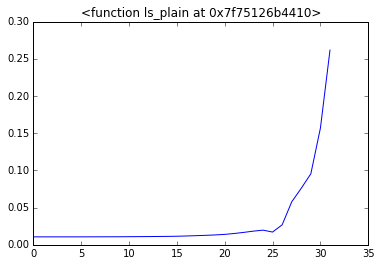

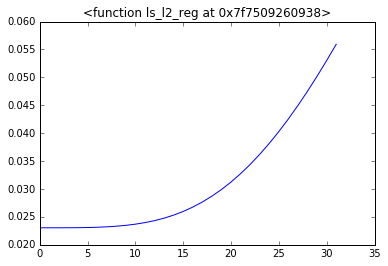

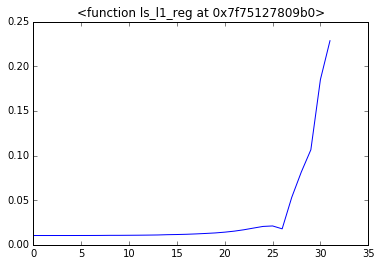

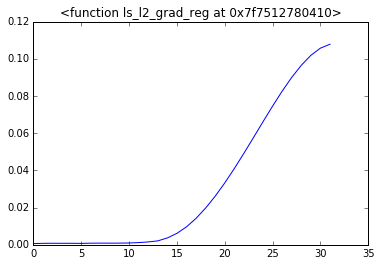

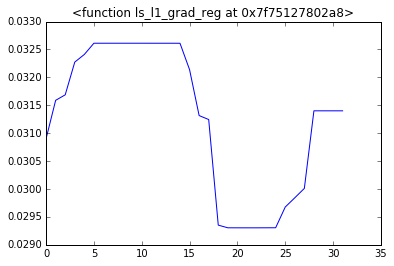

In [87]:
for ires, resi in enumerate(res):
    pl.figure()
    pl.title(funcopt[ires])
    pl.plot(resi.x)
pl.show()

In [55]:
x0 = np.ones(32)/32
# x0 = np.zeros(32)
# x0[0] = 1

In [56]:
data = np.random.rand(3*86)

In [62]:
res = fit_ls_func(x0, M[:,30], M)

`gtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 1485, CG iterations: 479, optimality: 3.31e-09, constraint violation: 2.22e-16, execution time: 0.25 s.


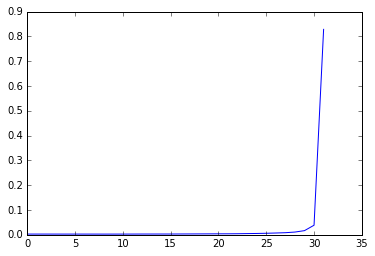

In [63]:
pl.plot(res.x)

In [64]:
res.fun

2.1809760238408273e-08

In [69]:
ls_func_sum(res.x, M, M[:,30])

2.1809760238408273e-08

In [71]:
xx = np.zeros(32)
xx[30] = 1
ls_func_sum(xx, M, M[:,30])

0.0